In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Full data

In [82]:
df = pd.read_json("results/task1/task1_data.json", lines=True)
#replace llama3.2 in the model column with llama3b
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
#replace llama3.2 in the model column with llama3b

#replace llama3.2 in the model column with llama3b
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')

df.drop(columns=['all_fit'], inplace=True)

df.rename(
    columns={
        'c_all_fit_hits': 'correct_match',
        'r_all_fit_hits': 'related_match',
        'r_all_fit_recall': 'related_recall'
    },
    inplace=True
)

code_path = "datasets/occupation.xlsx"
zone_path = "datasets/job_zone.xlsx"
# Read the Excel file
occupation = pd.read_excel(code_path)
occupation.drop(columns=['Description'], inplace=True)
occupation.columns = ['code', 'title']

zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']

# Merge the occupation data with the main dataframe
df = df.merge(occupation, left_on='title', right_on='title', how='left')
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["area"] = df["code"].apply(lambda x: x.split("-")[0])
df

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,area
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,9,0,1,0.2,mistral,persona,53-7071.00,2,53
73836,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,mistral,persona,53-7072.00,2,53
73837,Wellhead Pumpers,9,0,0,0.0,mistral,persona,53-7073.00,2,53
73838,Refuse and Recyclable Material Collectors,9,0,0,0.0,mistral,persona,53-7081.00,2,53


In [47]:
# Ensure correct data types (especially for categorical grouping)
df['zone'] = df['zone'].astype(str)
df['area'] = df['area'].astype(str)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=True)

outcome_metrics = ['correct_match', 'related_match', 'related_recall']
descriptive_stats = {}

print("--- Descriptive Statistics Overview ---")

models = df['model'].unique()
prompts = df['prompt'].unique()
# Loop through each model and calculate descriptive statistics


for model in models:
    df_model = df[df['model'] == model]
    for prompt in prompts:
        df_prompt = df_model[df_model['prompt'] == prompt]
        # 1. Overall Statistics
        print(f"\nOverall Performance {model} - {prompt} (Mean, Median, SD)")
        overall_stats = df_prompt[outcome_metrics].agg(['mean', 'median', 'std'])
        descriptive_stats[f'overall_{model}'] = overall_stats
        print(overall_stats)



--- Descriptive Statistics Overview ---

Overall Performance deepseek-r1 - benchmark (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.079198       0.267606        0.065038
median       0.000000       0.000000        0.000000
std          0.270063       0.442735        0.141248

Overall Performance deepseek-r1 - persona (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.218310        0.54442        0.177053
median       0.000000        1.00000        0.100000
std          0.413121        0.49805        0.220452

Overall Performance llama3b - benchmark (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.153738       0.392849        0.131528
median       0.000000       0.000000        0.000000
std          0.360717       0.488410        0.214908

Overall Performance llama3b - persona (Mean, Median, SD)
        correct_match  related_match  related_recall
mean         0.314735      

In [117]:
import pandas as pd
import numpy as np

# Ensure correct data types (especially for categorical grouping)
df['zone'] = df['zone'].astype(str)
df['area'] = df['area'].astype(str)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=True)
df['model'] = df['model'].astype('category') # Ensure model is a category

# --- 2. Define Outcome Metrics ---
outcome_metrics = ['correct_match', 'related_match', 'related_recall']

# --- 3. Generate the Descriptive Statistics Table (Per Model, Per Prompt) ---
print("--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---")

# Group by 'model' and 'prompt' and aggregate
model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])

# Unstack the 'prompt' level to make it the top-level column
# This gives the desired structure: Prompt -> Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats.unstack('prompt')

# # Optional: Improve column names for presentation
# model_prompt_stats_unstacked.columns = pd.MultiIndex.from_tuples([
#     (f"{prompt_level.capitalize()}", f"{metric_level.replace('_', ' ').title()}", stat_level)
#     for prompt_level, metric_level, stat_level in model_prompt_stats_unstacked.columns
# ])

# Sort columns for consistent order: Benchmark first, then persona
# And within each, Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats_unstacked.sort_index(axis=1, level=[0, 1, 2])

# Print the DataFrame (rounded for better readability)
print(model_prompt_stats_unstacked.round(3))



--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---
            correct_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.079   0.218       0.0     0.0     0.270   0.413   
llama3b             0.154   0.315       0.0     0.0     0.361   0.464   
llama70b            0.319   0.362       0.0     0.0     0.466   0.481   
mistral             0.112   0.228       0.0     0.0     0.315   0.419   

            related_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.268   0.544       0.0 

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3310939908.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])


In [136]:
outcome_metrics = ['correct_match', 'related_match', 'related_recall']
for metric in outcome_metrics:
    bch = model_prompt_stats_unstacked[(metric, 'mean', 'benchmark')]
    per = model_prompt_stats_unstacked[(metric, 'mean', 'persona')]
    # Calculate the percentage difference
    percentage_difference = ((per - bch) / bch) * 100
    # add the percentage difference to the DataFrame
    model_prompt_stats_unstacked[(metric,'mean', 'percentage_difference')] = percentage_difference
model_prompt_stats_unstacked.round(3)['relt'].sort_values(by=('mean', 'percentage_difference'), ascending=False)

mean            median               std          \
prompt      benchmark persona benchmark persona benchmark persona   
model                                                               
deepseek-r1     0.065   0.177       0.0     0.1     0.141   0.220   
llama3b         0.132   0.257       0.0     0.2     0.215   0.246   
mistral         0.100   0.193       0.0     0.1     0.181   0.235   
llama70b        0.256   0.292       0.2     0.3     0.248   0.255   

                             mean  
prompt      percentage_difference  
model                              
deepseek-r1               172.231  
llama3b                    95.198  
mistral                    91.962  
llama70b                   13.962

In [163]:
model_prompt_stats1 =df.groupby(['title', 'prompt', 'model'])[outcome_metrics].agg('mean')
model_prompt_stats1 = model_prompt_stats1.unstack('prompt')
model_prompt_stats1 = model_prompt_stats1.groupby('model').agg(['mean', 'median', 'std'])

for metric in outcome_metrics:
    bch = model_prompt_stats1[(metric, 'benchmark', 'mean')]
    per = model_prompt_stats1[(metric, 'persona', 'mean')]
    # Calculate the percentage difference
    percentage_difference = ((per - bch) / bch) * 100
    # add the percentage difference to the DataFrame
    model_prompt_stats1[(metric,'mean', '%diff')] = percentage_difference

model_prompt_stats1['related_recall'].round(3).sort_values(by=('mean', '%diff'), ascending=False)

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3179445145.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats1 =df.groupby(['title', 'prompt', 'model'])[outcome_metrics].agg('mean')
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3179445145.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats1 = model_prompt_stats1.groupby('model').agg(['mean', 'median', 'std'])


prompt      benchmark               persona                   mean
                 mean median    std    mean median    std    %diff
model                                                             
deepseek-r1     0.065   0.04  0.078   0.177   0.14  0.157  172.231
llama3b         0.132   0.06  0.162   0.257   0.22  0.200   95.198
mistral         0.100   0.06  0.119   0.193   0.12  0.201   91.962
llama70b        0.256   0.20  0.237   0.292   0.26  0.249   13.962

In [130]:

# 3. Statistics by Model (LLM)
print("\n3. Performance by LLM Model (Mean, Median, SD)")
model_stats = df.groupby('model')[outcome_metrics].agg(['mean', 'median', 'std'])
descriptive_stats['by_model'] = model_stats
print(model_stats) # Print DataFrame directly


# 4. Statistics by Model and Prompt Type
print("\n4. Performance by LLM Model and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Model)")
model_prompt_stats_agg = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])

diff_rows = []
for model_name in df['model'].unique():
    if (model_name, 'persona') in model_prompt_stats_agg.index and \
       (model_name, 'benchmark') in model_prompt_stats_agg.index:
        
        persona_row = model_prompt_stats_agg.loc[(model_name, 'persona')]
        benchmark_row = model_prompt_stats_agg.loc[(model_name, 'benchmark')]
        
        diff_means = (persona_row.xs('mean', level=1) - benchmark_row.xs('mean', level=1))
        diff_row_data = { (metric, 'mean'): diff_means[metric] for metric in outcome_metrics}
        diff_row = pd.DataFrame([diff_row_data], index=pd.MultiIndex.from_tuples([(model_name, 'difference')], names=['model', 'prompt']), columns=model_prompt_stats_agg.columns)
        
        pct_change_means = {}
        for metric in outcome_metrics:
            pct_change_mean = np.nan
            if benchmark_row[(metric, 'mean')] != 0:
                pct_change_mean = ((persona_row[(metric, 'mean')] - benchmark_row[(metric, 'mean')]) / benchmark_row[(metric, 'mean')]) * 100
            pct_change_means[(metric, 'mean')] = pct_change_mean
        pct_change_row_data = { (metric, 'mean'): pct_change_means[ (metric, 'mean')] for metric in outcome_metrics}
        pct_change_row = pd.DataFrame([pct_change_row_data], index=pd.MultiIndex.from_tuples([(model_name, '%_change')], names=['model', 'prompt']), columns=model_prompt_stats_agg.columns)

        diff_rows.append(diff_row)
        diff_rows.append(pct_change_row)
        
if diff_rows:
    diff_df_combined = pd.concat(diff_rows)
    model_prompt_stats_full = pd.concat([model_prompt_stats_agg, diff_df_combined])
    model_prompt_stats_full = model_prompt_stats_full.sort_index(level=['model', 'prompt'])
    for (metric, stat) in model_prompt_stats_full.columns:
        if stat in ['median', 'std']:
            model_prompt_stats_full.loc[(slice(None), ['difference', '%_change']), (metric, stat)] = np.nan

else:
    model_prompt_stats_full = model_prompt_stats_agg
    
descriptive_stats['by_model_and_prompt'] = model_prompt_stats_full
# Helper to calculate stats and diff for area/zone
def calculate_grouped_stats_and_diff(df, group_col, outcome_metrics):
    grouped_stats_agg = df.groupby([group_col, 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])
    
    diff_rows = []
    unique_groups = df[group_col].unique()
    for group_val in unique_groups:
        if (group_val, 'persona') in grouped_stats_agg.index and \
           (group_val, 'benchmark') in grouped_stats_agg.index:
            
            persona_row = grouped_stats_agg.loc[(group_val, 'persona')]
            benchmark_row = grouped_stats_agg.loc[(group_val, 'benchmark')]
            
            diff_means = (persona_row.xs('mean', level=1) - benchmark_row.xs('mean', level=1))
            diff_row_data = { (metric, 'mean'): diff_means[metric] for metric in outcome_metrics}
            diff_row = pd.DataFrame([diff_row_data], index=pd.MultiIndex.from_tuples([(group_val, 'difference')], names=[group_col, 'prompt']), columns=grouped_stats_agg.columns)
            
            pct_change_means = {}
            for metric in outcome_metrics:
                pct_change_mean = np.nan
                if benchmark_row[(metric, 'mean')] != 0:
                    pct_change_mean = ((persona_row[(metric, 'mean')] - benchmark_row[(metric, 'mean')]) / benchmark_row[(metric, 'mean')]) * 100
                pct_change_means[(metric, 'mean')] = pct_change_mean
            pct_change_row_data = { (metric, 'mean'): pct_change_means[ (metric, 'mean')] for metric in outcome_metrics}
            pct_change_row = pd.DataFrame([pct_change_row_data], index=pd.MultiIndex.from_tuples([(group_val, '%_change')], names=[group_col, 'prompt']), columns=grouped_stats_agg.columns)
            
            diff_rows.append(diff_row)
            diff_rows.append(pct_change_row)
            
    if diff_rows:
        diff_df_combined = pd.concat(diff_rows)
        full_stats = pd.concat([grouped_stats_agg, diff_df_combined])
        full_stats = full_stats.sort_index(level=[group_col, 'prompt'])
        for (metric, stat) in full_stats.columns:
            if stat in ['median', 'std']:
                full_stats.loc[(slice(None), ['difference', '%_change']), (metric, stat)] = np.nan
    else:
        full_stats = grouped_stats_agg
    return full_statsprint(model_prompt_stats_full) # Print DataFrame directly


3. Performance by LLM Model (Mean, Median, SD)
            correct_match                  related_match                   \
                     mean median       std          mean median       std   
model                                                                       
deepseek-r1      0.148754    0.0  0.355856      0.406013    0.0  0.491100   
llama3b          0.234236    0.0  0.423532      0.550921    1.0  0.497414   
llama70b         0.340412    0.0  0.473860      0.720531    1.0  0.448751   
mistral          0.169664    0.0  0.375348      0.451733    0.0  0.497678   

            related_recall                   
                      mean median       std  
model                                        
deepseek-r1       0.121046    0.0  0.193417  
llama3b           0.194133    0.1  0.239138  
llama70b          0.273954    0.2  0.252176  
mistral           0.146582    0.0  0.214612  

4. Performance by LLM Model and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark 

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2922921087.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_stats = df.groupby('model')[outcome_metrics].agg(['mean', 'median', 'std'])
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2922921087.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats_agg = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])


In [ ]:


# 5. Statistics by Job Area (Industry)
print("\n5. Performance by Job Area (Industry) and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Area)")
area_stats_full = calculate_grouped_stats_and_diff(df, 'area', outcome_metrics)
descriptive_stats['by_area_and_prompt'] = area_stats_full
print(area_stats_full) # Print DataFrame directly

# 6. Statistics by Complexity Zone
print("\n6. Performance by Complexity Zone and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Zone)")
zone_stats_full = calculate_grouped_stats_and_diff(df, 'zone', outcome_metrics)
descriptive_stats['by_zone_and_prompt'] = zone_stats_full
print(zone_stats_full) # Print DataFrame directly

# You can access individual dataframes like:
# descriptive_stats['overall']
# descriptive_stats['by_prompt']
# descriptive_stats['by_area_and_prompt']

In [30]:
# 2. Statistics by Prompt Type
print("\n2. Performance by Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference)")
prompt_stats_agg = df.groupby('prompt')[outcome_metrics].agg(['mean', 'median', 'std'])

# We want prompt as index, and (metric, stat) as columns
# The agg method already gives us a MultiIndex column (metric, stat)
# prompt_stats_agg already has the desired structure, no need for complex unstacking/swapping
prompt_stats = prompt_stats_agg.copy()

# Calculate difference and percentage difference
diff_data = {}
pct_change_data = {}

for metric in outcome_metrics:
    persona_mean = prompt_stats_agg.loc['persona', (metric, 'mean')]
    benchmark_mean = prompt_stats_agg.loc['benchmark', (metric, 'mean')]
    
    diff_data[(metric, 'mean')] = persona_mean - benchmark_mean
    
    # Handle potential division by zero if benchmark mean is 0
    if benchmark_mean != 0:
        pct_change_data[(metric, 'mean')] = ((persona_mean - benchmark_mean) / benchmark_mean) * 100
    else:
        pct_change_data[(metric, 'mean')] = np.nan # Or specific string like 'Inf'

# Create DataFrame rows for difference and percentage change
diff_df = pd.DataFrame([diff_data], index=['difference'])
pct_change_df = pd.DataFrame([pct_change_data], index=['%_change'])

# Concatenate these rows to the original prompt_stats DataFrame
prompt_stats = pd.concat([prompt_stats, diff_df, pct_change_df])

# Fill NaN for median/std in the difference/%_change rows
for metric in outcome_metrics:
    for stat in ['median', 'std']:
        if (metric, stat) in prompt_stats.columns:
             prompt_stats.loc[['difference', '%_change'], (metric, stat)] = np.nan


descriptive_stats['by_prompt'] = prompt_stats
print(prompt_stats.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))

# 3. Statistics by Model (LLM)
print("\n3. Performance by LLM Model (Mean, Median, SD)")
model_stats = df.groupby('model')[outcome_metrics].agg(['mean', 'median', 'std'])
descriptive_stats['by_model'] = model_stats
print(model_stats.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))


# 4. Statistics by Model and Prompt Type
print("\n4. Performance by LLM Model and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Model)")
model_prompt_stats_agg = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])

# Calculate difference and percentage difference for each model
diff_rows = []
for model_name in df['model'].unique():
    if (model_name, 'persona') in model_prompt_stats_agg.index and \
       (model_name, 'benchmark') in model_prompt_stats_agg.index:
        
        persona_row = model_prompt_stats_agg.loc[(model_name, 'persona')]
        benchmark_row = model_prompt_stats_agg.loc[(model_name, 'benchmark')]
        
        # Calculate difference (mean values)
        diff_means = (persona_row.xs('mean', level=1) - benchmark_row.xs('mean', level=1))
        diff_row_data = { (metric, 'mean'): diff_means[metric] for metric in outcome_metrics}
        diff_row = pd.DataFrame([diff_row_data], index=pd.MultiIndex.from_tuples([(model_name, 'difference')], names=['model', 'prompt']), columns=model_prompt_stats_agg.columns)
        
        # Calculate % change (mean values)
        pct_change_means = {}
        for metric in outcome_metrics:
            pct_change_mean = np.nan
            if benchmark_row[(metric, 'mean')] != 0:
                pct_change_mean = ((persona_row[(metric, 'mean')] - benchmark_row[(metric, 'mean')]) / benchmark_row[(metric, 'mean')]) * 100
            pct_change_means[(metric, 'mean')] = pct_change_mean
        pct_change_row_data = { (metric, 'mean'): pct_change_means[ (metric, 'mean')] for metric in outcome_metrics}
        pct_change_row = pd.DataFrame([pct_change_row_data], index=pd.MultiIndex.from_tuples([(model_name, '%_change')], names=['model', 'prompt']), columns=model_prompt_stats_agg.columns)

        diff_rows.append(diff_row)
        diff_rows.append(pct_change_row)
        
if diff_rows:
    diff_df_combined = pd.concat(diff_rows)
    # Concatenate with original and ensure proper sorting
    model_prompt_stats_full = pd.concat([model_prompt_stats_agg, diff_df_combined])
    model_prompt_stats_full = model_prompt_stats_full.sort_index(level=['model', 'prompt']) # Sort by model then prompt type
    # Fill NaN for median/std in the difference/%_change rows
    for (metric, stat) in model_prompt_stats_full.columns:
        if stat in ['median', 'std']:
            model_prompt_stats_full.loc[(slice(None), ['difference', '%_change']), (metric, stat)] = np.nan

else:
    model_prompt_stats_full = model_prompt_stats_agg
    
descriptive_stats['by_model_and_prompt'] = model_prompt_stats_full
print(model_prompt_stats_full.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))


# Helper to calculate stats and diff for area/zone
def calculate_grouped_stats_and_diff(df, group_col, outcome_metrics):
    grouped_stats_agg = df.groupby([group_col, 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])
    
    # Calculate differences
    diff_rows = []
    unique_groups = df[group_col].unique()
    for group_val in unique_groups:
        if (group_val, 'persona') in grouped_stats_agg.index and \
           (group_val, 'benchmark') in grouped_stats_agg.index:
            
            persona_row = grouped_stats_agg.loc[(group_val, 'persona')]
            benchmark_row = grouped_stats_agg.loc[(group_val, 'benchmark')]
            
            # Calculate difference (mean values)
            diff_means = (persona_row.xs('mean', level=1) - benchmark_row.xs('mean', level=1))
            diff_row_data = { (metric, 'mean'): diff_means[metric] for metric in outcome_metrics}
            diff_row = pd.DataFrame([diff_row_data], index=pd.MultiIndex.from_tuples([(group_val, 'difference')], names=[group_col, 'prompt']), columns=grouped_stats_agg.columns)
            
            # Calculate % change (mean values)
            pct_change_means = {}
            for metric in outcome_metrics:
                pct_change_mean = np.nan
                if benchmark_row[(metric, 'mean')] != 0:
                    pct_change_mean = ((persona_row[(metric, 'mean')] - benchmark_row[(metric, 'mean')]) / benchmark_row[(metric, 'mean')]) * 100
                pct_change_means[(metric, 'mean')] = pct_change_mean
            pct_change_row_data = { (metric, 'mean'): pct_change_means[ (metric, 'mean')] for metric in outcome_metrics}
            pct_change_row = pd.DataFrame([pct_change_row_data], index=pd.MultiIndex.from_tuples([(group_val, '%_change')], names=[group_col, 'prompt']), columns=grouped_stats_agg.columns)
            
            diff_rows.append(diff_row)
            diff_rows.append(pct_change_row)
            
    if diff_rows:
        diff_df_combined = pd.concat(diff_rows)
        # Concatenate with original and ensure proper sorting
        full_stats = pd.concat([grouped_stats_agg, diff_df_combined])
        full_stats = full_stats.sort_index(level=[group_col, 'prompt']) # Sort by group_col then prompt type
        # Fill NaN for median/std in the difference/%_change rows
        for (metric, stat) in full_stats.columns:
            if stat in ['median', 'std']:
                full_stats.loc[(slice(None), ['difference', '%_change']), (metric, stat)] = np.nan
    else:
        full_stats = grouped_stats_agg
    return full_stats

# 5. Statistics by Job Area (Industry)
print("\n5. Performance by Job Area (Industry) and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Area)")
area_stats_full = calculate_grouped_stats_and_diff(df, 'area', outcome_metrics)
descriptive_stats['by_area_and_prompt'] = area_stats_full
print(area_stats_full.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))

# 6. Statistics by Complexity Zone
print("\n6. Performance by Complexity Zone and Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference per Zone)")
zone_stats_full = calculate_grouped_stats_and_diff(df, 'zone', outcome_metrics)
descriptive_stats['by_zone_and_prompt'] = zone_stats_full
print(zone_stats_full.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))

# You can access individual dataframes like:
# descriptive_stats['overall']
# descriptive_stats['by_prompt']
# descriptive_stats['by_area_and_prompt']


2. Performance by Prompt Type (Mean, Median, SD, and Persona vs. Benchmark Difference)
|            | ('correct_match', 'mean')   | ('correct_match', 'median')   | ('correct_match', 'std')   | ('related_match', 'mean')   | ('related_match', 'median')   | ('related_match', 'std')   | ('related_recall', 'mean')   | ('related_recall', 'median')   | ('related_recall', 'std')   |
|:-----------|:----------------------------|:------------------------------|:---------------------------|:----------------------------|:------------------------------|:---------------------------|:-----------------------------|:-------------------------------|:----------------------------|
| benchmark  | 0.166                       | 0.000                         | 0.372                      | 0.425                       | 0.000                         | 0.494                      | 0.138                        | 0.000                          | 0.213                       |
| persona    | 0.281                   

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3431377955.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prompt_stats_agg = df.groupby('prompt')[outcome_metrics].agg(['mean', 'median', 'std'])
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3431377955.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats_agg = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3431377955.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

In [3]:
df_test = df[df['model'] == 'mistral']
df_test

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,area
55380,Chief Executives,0,0,1,0.4,mistral,benchmark,11-1011.00,5,11
55381,Chief Sustainability Officers,0,0,0,0.0,mistral,benchmark,11-1011.03,5,11
55382,General and Operations Managers,0,0,1,0.5,mistral,benchmark,11-1021.00,4,11
55383,Legislators,0,0,0,0.0,mistral,benchmark,11-1031.00,4,11
55384,Advertising and Promotions Managers,0,0,1,0.8,mistral,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,9,0,1,0.2,mistral,persona,53-7071.00,2,53
73836,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,mistral,persona,53-7072.00,2,53
73837,Wellhead Pumpers,9,0,0,0.0,mistral,persona,53-7073.00,2,53
73838,Refuse and Recyclable Material Collectors,9,0,0,0.0,mistral,persona,53-7081.00,2,53


Averaged match rate

In [5]:
df_avg = df.groupby(["title", "model", "prompt", "code", "zone", "area"]).mean().reset_index().drop(columns=["iteration"])
df_avg

,title,model,prompt,code,zone,area,correct_match,related_match,related_recall
0,Accountants and Auditors,deepseek-r1,benchmark,13-2011.00,4,13,0.0,0.0,0.00
1,Accountants and Auditors,deepseek-r1,persona,13-2011.00,4,13,0.0,1.0,0.59
2,Accountants and Auditors,llama3b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
3,Accountants and Auditors,llama3b,persona,13-2011.00,4,13,0.0,1.0,0.60
4,Accountants and Auditors,llama70b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
...,...,...,...,...,...,...,...,...,...
7379,Zoologists and Wildlife Biologists,llama3b,persona,19-1023.00,4,19,0.0,1.0,0.40
7380,Zoologists and Wildlife Biologists,llama70b,benchmark,19-1023.00,4,19,0.0,1.0,0.33
7381,Zoologists and Wildlife Biologists,llama70b,persona,19-1023.00,4,19,0.0,1.0,0.39
7382,Zoologists and Wildlife Biologists,mistral,benchmark,19-1023.00,4,19,0.0,0.0,0.00


Correct Match Pivot

In [8]:
df_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
df_pivot["difference"] = df_pivot["persona"] - df_pivot["benchmark"]
df_related_hit_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
df_related_hit_pivot["difference"] = df_related_hit_pivot["persona"] - df_related_hit_pivot["benchmark"]
df_recall_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_recall").reset_index()
df_recall_pivot["difference"] = df_recall_pivot["persona"] - df_recall_pivot["benchmark"]
df_pivot

prompt,title,area,zone,model,iteration,benchmark,persona,difference
0,Accountants and Auditors,13,4,deepseek-r1,0,0.0,0.0,0.0
1,Accountants and Auditors,13,4,deepseek-r1,1,0.0,0.0,0.0
2,Accountants and Auditors,13,4,deepseek-r1,2,0.0,0.0,0.0
3,Accountants and Auditors,13,4,deepseek-r1,3,0.0,0.0,0.0
4,Accountants and Auditors,13,4,deepseek-r1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36915,Zoologists and Wildlife Biologists,19,4,mistral,5,0.0,0.0,0.0
36916,Zoologists and Wildlife Biologists,19,4,mistral,6,0.0,0.0,0.0
36917,Zoologists and Wildlife Biologists,19,4,mistral,7,0.0,0.0,0.0
36918,Zoologists and Wildlife Biologists,19,4,mistral,8,0.0,0.0,0.0


In [9]:
deepseek = df_avg[df_avg["model"] == "deepseek-r1"]
llama3b = df_avg[df_avg["model"] == "llama3b"]
llama70b = df_avg[df_avg["model"] == "llama70b"]
mistral = df_avg[df_avg["model"] == "mistral"]

### Descriptive Stats

### Correct Match

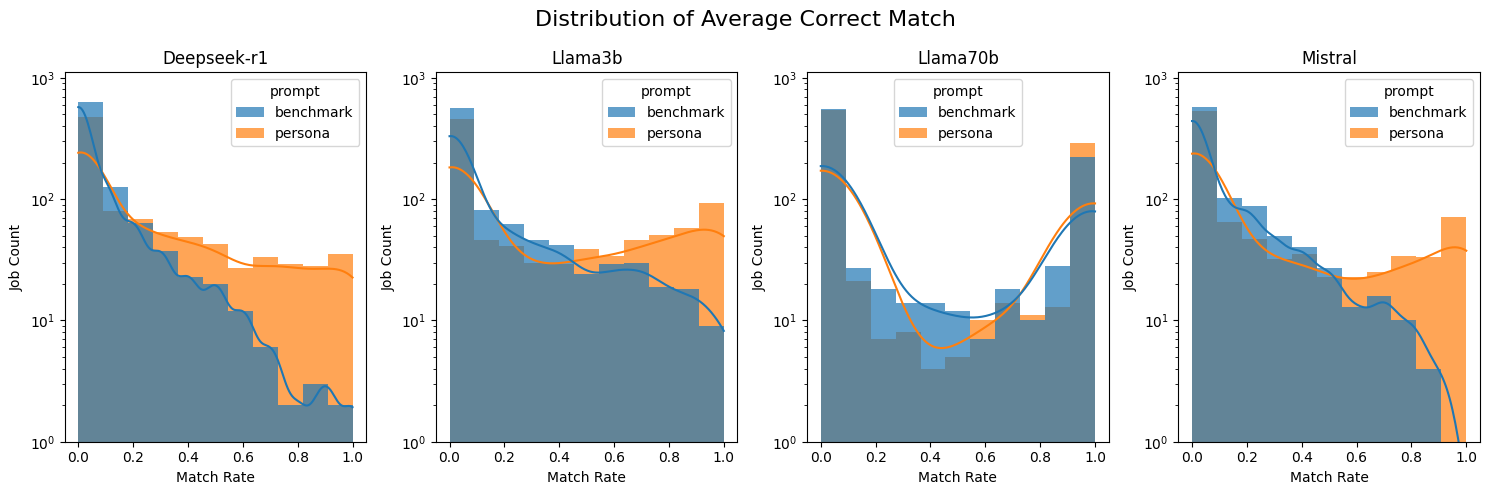

In [400]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["correct_match"].value_counts().max(),
    llama3b["correct_match"].value_counts().max(),
    llama70b["correct_match"].value_counts().max(),
    mistral["correct_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Correct Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="correct_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

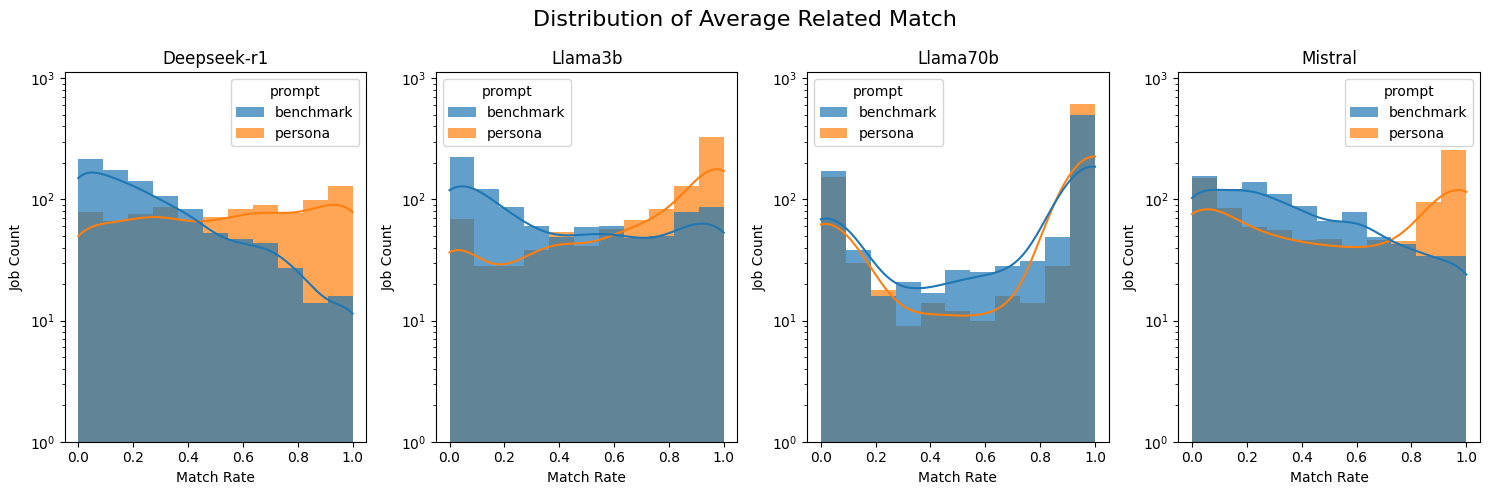

In [401]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["related_match"].value_counts().max(),
    llama3b["related_match"].value_counts().max(),
    llama70b["related_match"].value_counts().max(),
    mistral["related_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Related Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="related_match", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Match Rate")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

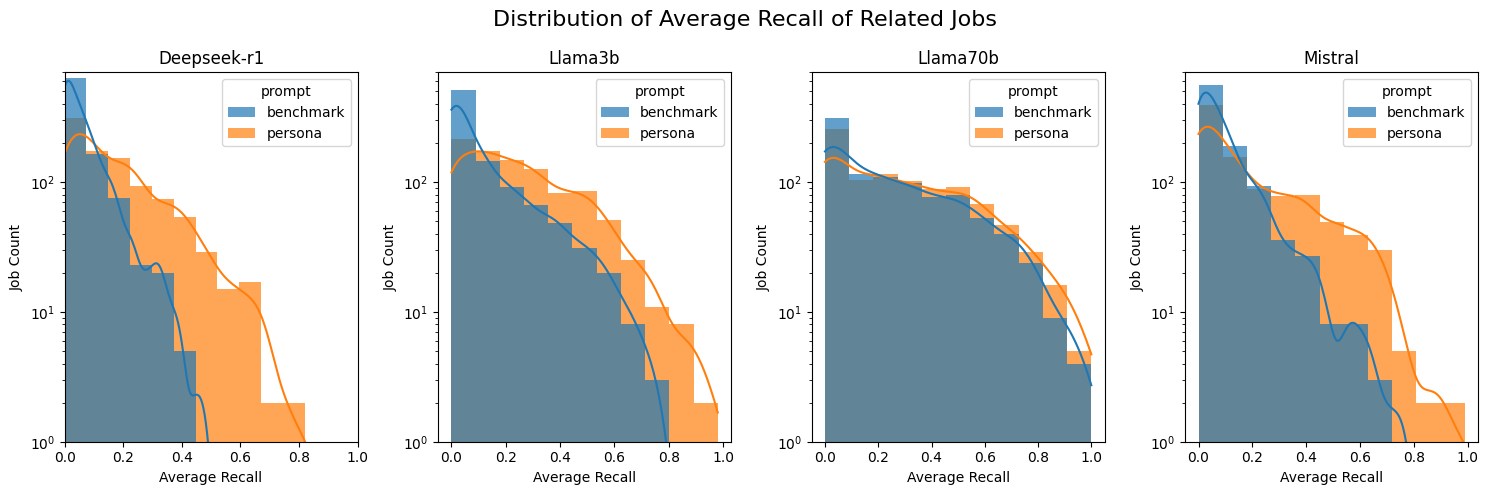

In [402]:
plt.figure(figsize=(15, 5))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["related_recall"].value_counts().max(),
    llama3b["related_recall"].value_counts().max(),
    llama70b["related_recall"].value_counts().max(),
    mistral["related_recall"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Recall of Related Jobs", fontsize=16)
# Plot the distribution of the data
plt.subplot(1, 4, 1)
sns.histplot(data=deepseek, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.xlim(0, 1)  # Set x-axis limit to [0, 1]
plt.title("Deepseek-r1")

plt.subplot(1,4, 2)
sns.histplot(data=llama3b, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(1, 4, 3)
sns.histplot(data=llama70b, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(1, 4, 4)
sns.histplot(data=mistral, x="related_recall", hue="prompt", bins=11, kde=True, alpha=0.7, edgecolor=None,)  
plt.xlabel("Average Recall")
plt.ylabel("Job Count")
plt.yscale('log')
plt.ylim(1, 700)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

more occupations get a higher correct match rate using persona than benchmark. For llama70b, more occupations get a 100% correct match than benchmark.

In [597]:
df_avg.query("model == 'mistral'and zone == 5" )[["prompt", "related_match", "related_recall"]].groupby("prompt").mean().round(3).sort_values(by="related_recall", ascending=False)

,related_match,related_recall
prompt,,
persona,0.830,0.354
benchmark,0.488,0.175


In [583]:
df_avg

,title,model,prompt,code,zone,area,correct_match,related_match,related_recall
0,Accountants and Auditors,deepseek-r1,benchmark,13-2011.00,4,13,0.0,0.0,0.00
1,Accountants and Auditors,deepseek-r1,persona,13-2011.00,4,13,0.0,1.0,0.59
2,Accountants and Auditors,llama3b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
3,Accountants and Auditors,llama3b,persona,13-2011.00,4,13,0.0,1.0,0.60
4,Accountants and Auditors,llama70b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
...,...,...,...,...,...,...,...,...,...
7379,Zoologists and Wildlife Biologists,llama3b,persona,19-1023.00,4,19,0.0,1.0,0.40
7380,Zoologists and Wildlife Biologists,llama70b,benchmark,19-1023.00,4,19,0.0,1.0,0.33
7381,Zoologists and Wildlife Biologists,llama70b,persona,19-1023.00,4,19,0.0,1.0,0.39
7382,Zoologists and Wildlife Biologists,mistral,benchmark,19-1023.00,4,19,0.0,0.0,0.00


looking at Average correct match = 0, at least half of the occupation do not get a match in all 10 rounds. However, persona prompt helped more occupation to get more matches.

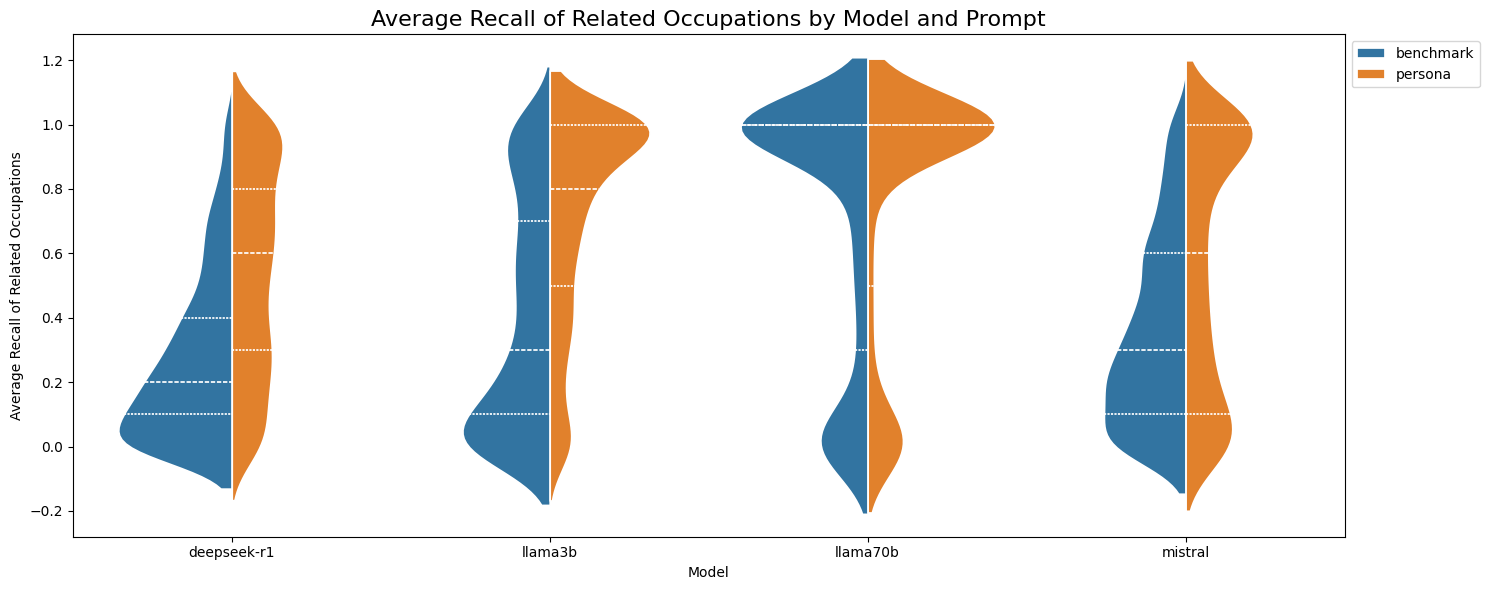

In [407]:
# Calculate the average related_match for each model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["related_match"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(15, 6))

# sns.stripplot(data=df_avg, x="model", y="related_match", hue="prompt", dodge=True, 
#               size=5, alpha=0.05, jitter=True)
sns.violinplot(data=df_avg, x="model", y="related_match", hue="prompt", split=True, inner="quartile",bw_adjust=1, alpha=1, edgecolor="white")

# Add labels and title
plt.title("Average Recall of Related Occupations by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average Recall of Related Occupations")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3669075115.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()


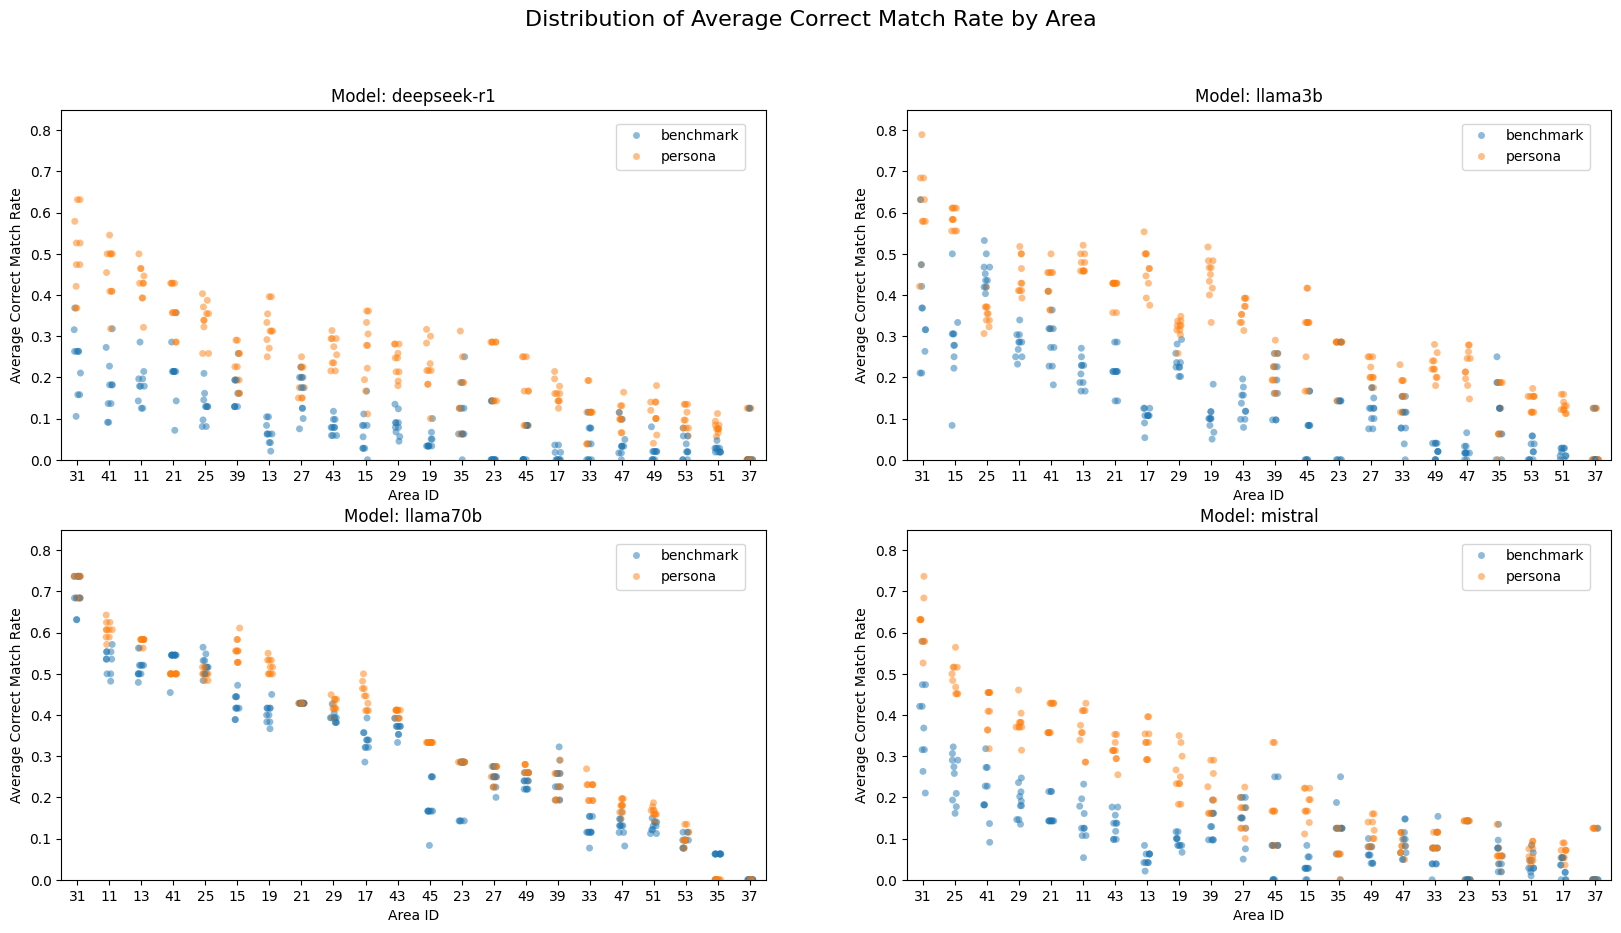

In [345]:
df_avg_area = df_avg.groupby(["area", "model", "prompt"])["correct_match"].mean().reset_index()
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 10))
plt.suptitle("Distribution of Average Correct Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model.groupby('area')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="correct_match", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Average Correct Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.85)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\340128253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()


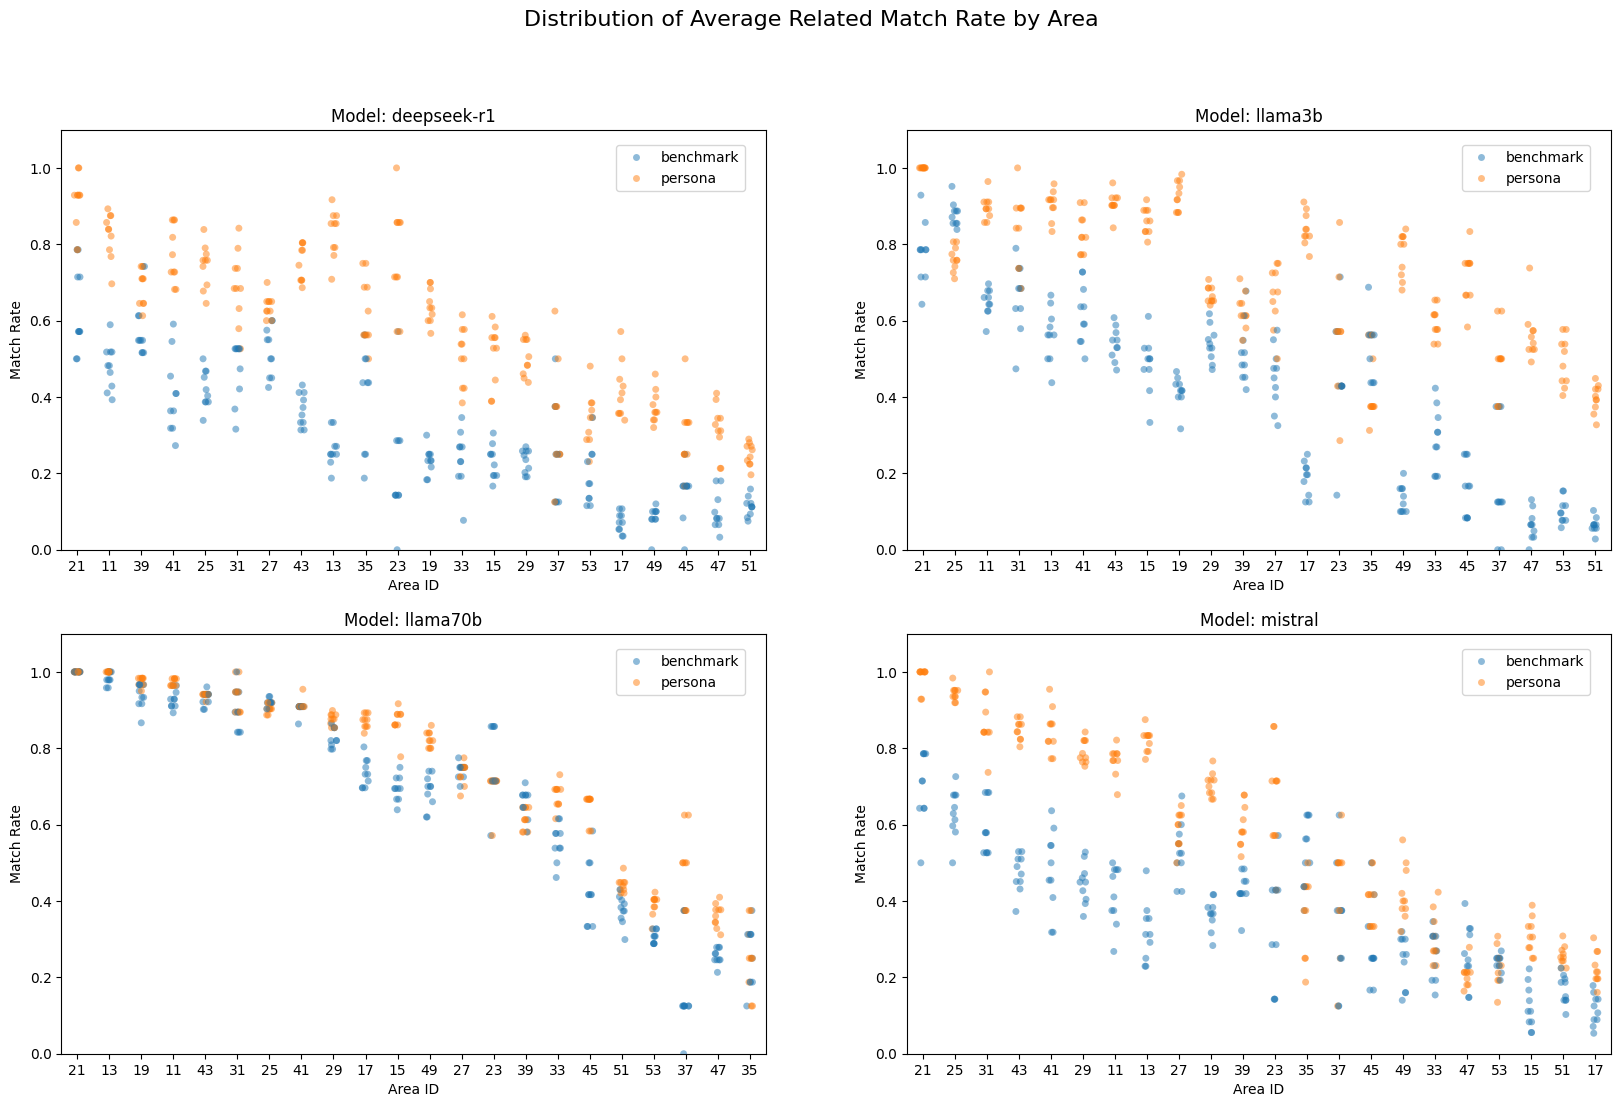

In [279]:
df_avg_area = df_avg.groupby(["area", "model", "prompt"])["related_match"].mean().reset_index()
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Related Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model.groupby('area')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_match", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1.1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\1887590645.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()


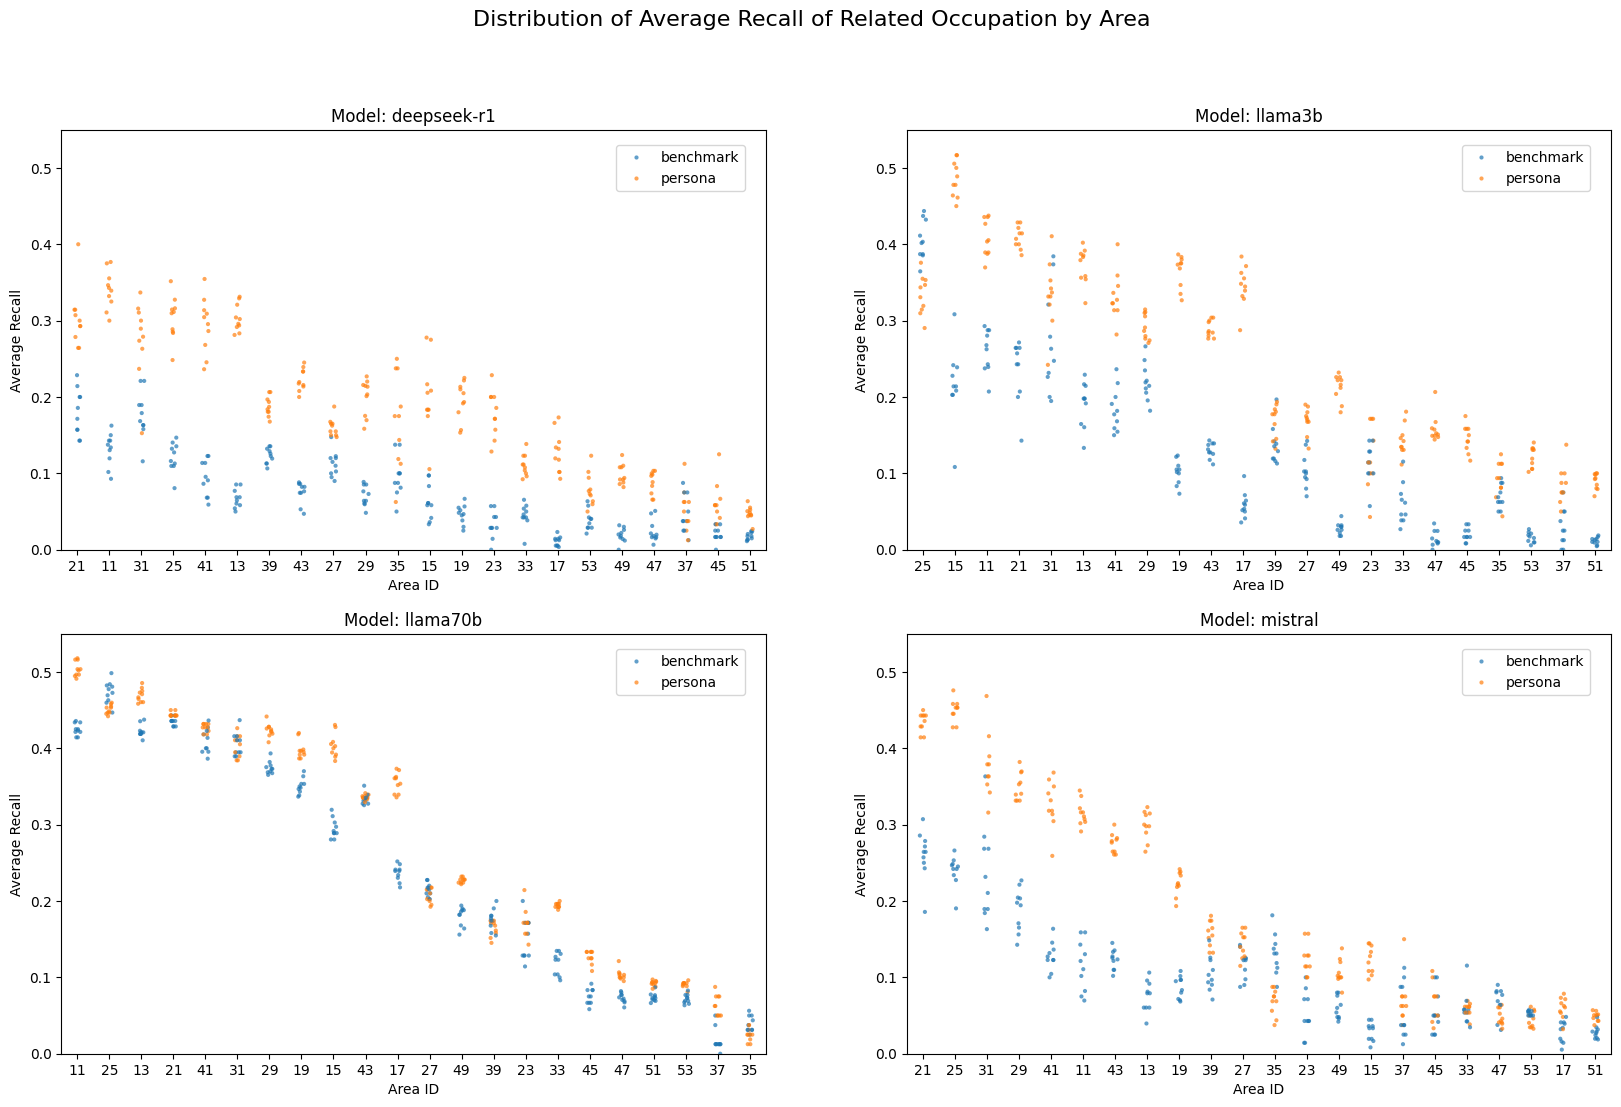

In [517]:
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Recall of Related Occupation by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model.groupby('area')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_recall", hue="prompt", dodge=False, 
              size=3, alpha=0.7, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Average Recall')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.55)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2693592726.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_change = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2693592726.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2693592726.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

<Figure size 800x600 with 0 Axes>

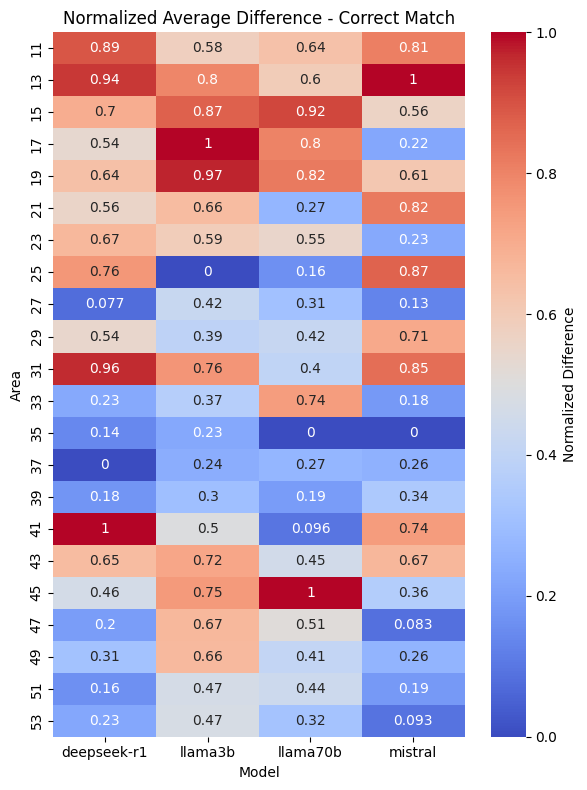

In [472]:
area_change = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()
area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="correct_match").reset_index()
area_change["difference"] = (area_change["persona"] - area_change["benchmark"])
area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=area_change, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Correct Match")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\1992158752.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_change = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\1992158752.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="related_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\1992158752.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

<Figure size 800x600 with 0 Axes>

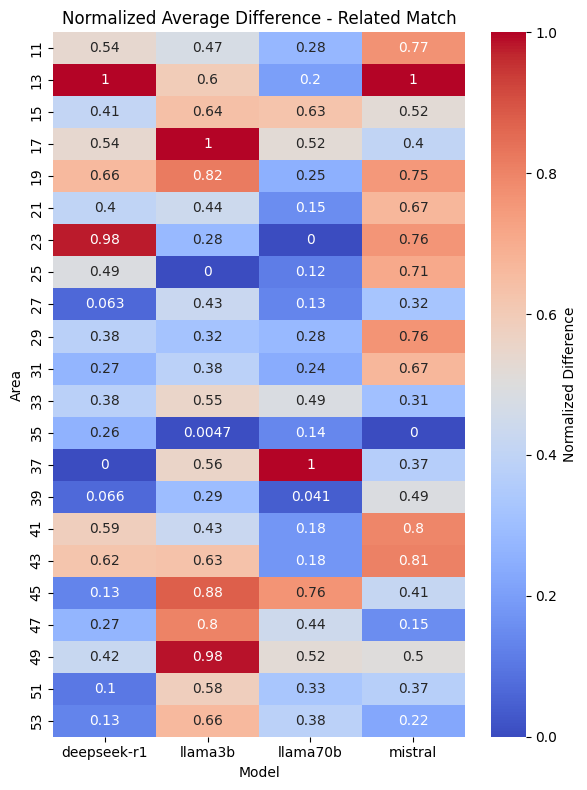

In [473]:
area_change = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()
area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="related_match").reset_index()
area_change["difference"] = (area_change["persona"] - area_change["benchmark"])
area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=area_change, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Related Match")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3153064049.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_change = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3153064049.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="related_recall").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3153064049.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

<Figure size 800x600 with 0 Axes>

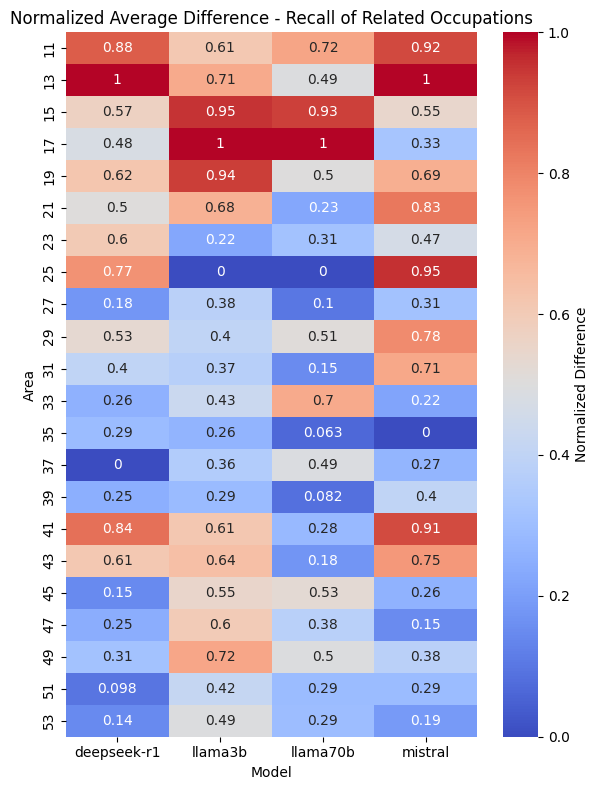

In [474]:
area_change = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()
area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values="related_recall").reset_index()
area_change["difference"] = (area_change["persona"] - area_change["benchmark"])
area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=area_change, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Recall of Related Occupations")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\1422397432.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()


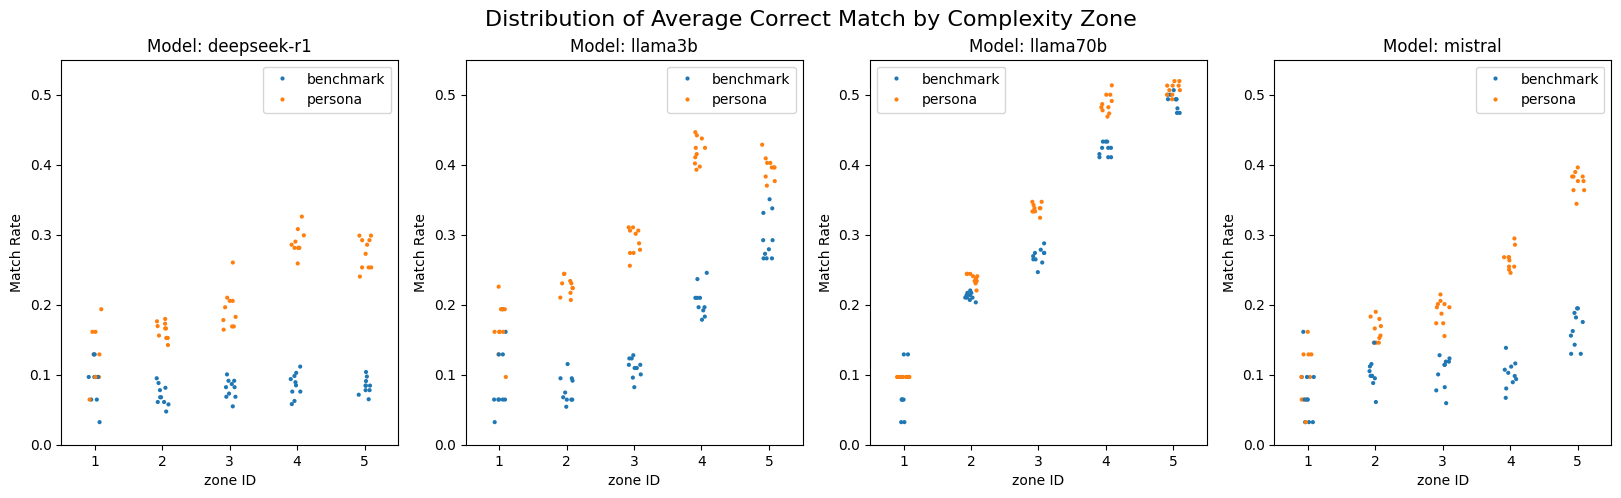

In [516]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 5))
plt.suptitle("Distribution of Average Correct Match by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="correct_match", hue="prompt", dodge=False, 
              size=3, alpha=1, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.55)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3003704244.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()


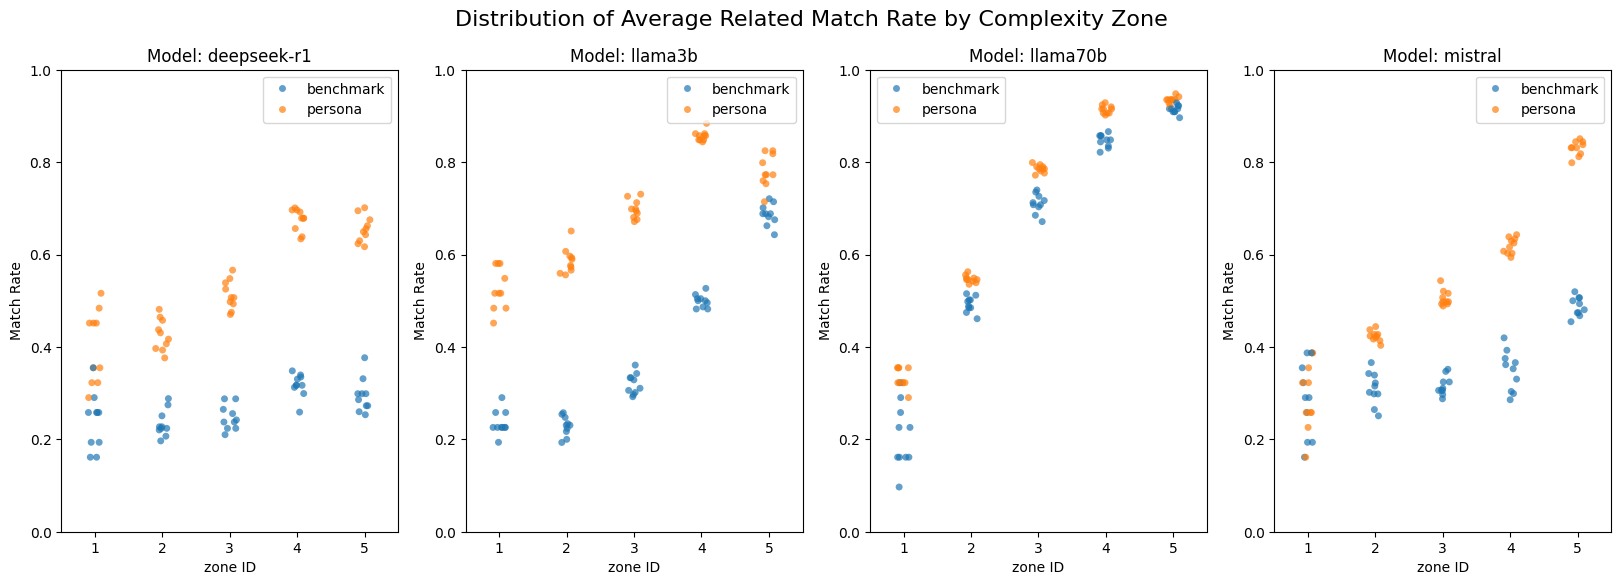

In [503]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 6))
plt.suptitle("Distribution of Average Related Match Rate by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_match", hue="prompt", dodge=False, 
              size=5, alpha=0.7, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\934167155.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()


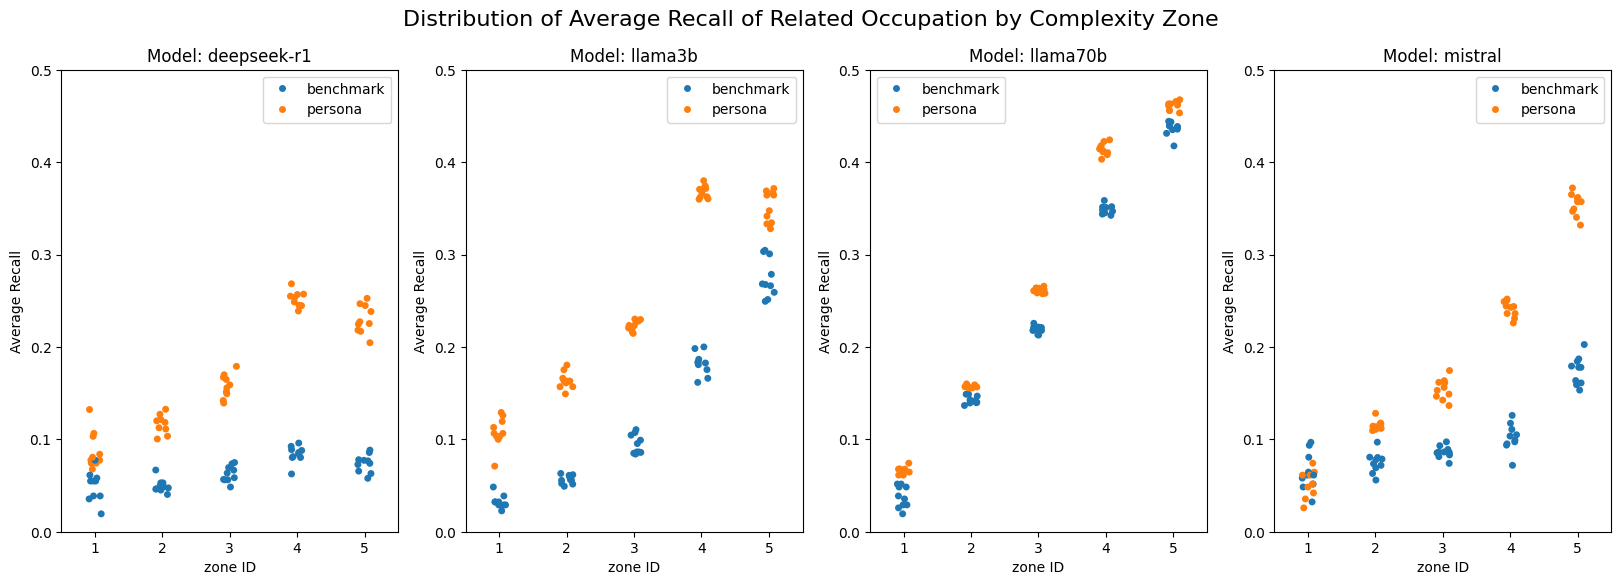

In [ ]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 6))
plt.suptitle("Distribution of Average Recall of Related Occupation by Complexity Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_recall", hue="prompt", dodge=False, 
              size=5, alpha=1, jitter=True)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Average Recall')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, .5)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])#, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3906643036.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3906643036.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\3906643036.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

<Figure size 800x600 with 0 Axes>

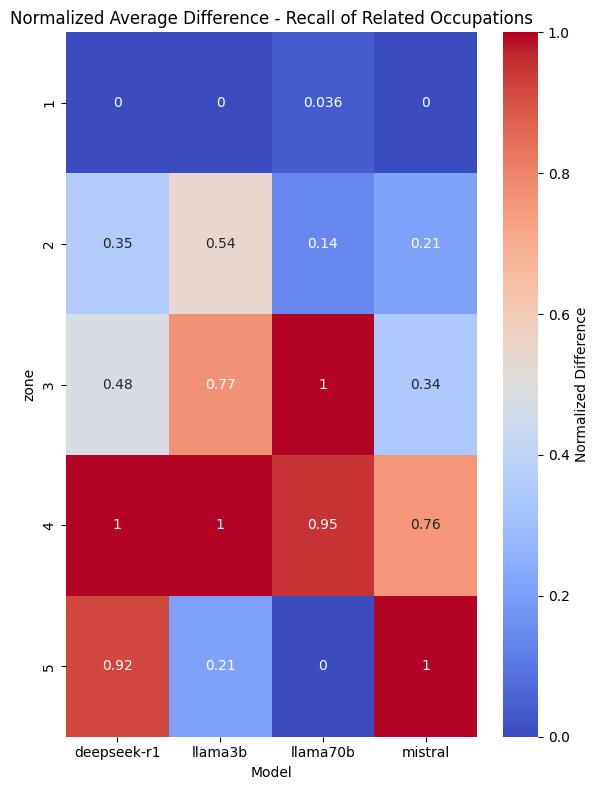

In [520]:
zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
zone_change["difference"] = (zone_change["persona"] - zone_change["benchmark"])
zone_change["normalized_difference"] = zone_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=zone_change, x="zone", y="normalized_difference", hue="model")
# Pivot the data so that rows are zone, columns are model, and values are normalized_difference
heatmap_data = zone_change.pivot(index="zone", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Recall of Related Occupations")
plt.xlabel("Model")
plt.ylabel("zone")
plt.tight_layout()
plt.show()

In [15]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

for model in models:
    # Filter the dataframe for the current model
    model_data = df_pivot[df_pivot['model'] == model].copy()
    model_data = model_data.groupby(["title", "model", "area", "zone"]).mean().reset_index().drop(columns=["iteration"])
    model_data['difference'] = model_data['persona'] - model_data['benchmark']

    # Perform the Wilcoxon signed-rank test on the differences
    statistic, p_value = stats.wilcoxon(model_data['persona'], model_data["benchmark"], alternative='greater')
    # Print the results

    print(f"Model: {model}")
    print("Wilcoxon Signed-Rank Test Results:")
    print(f"  W-statistic: {statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")

    # Interpretation of the p-value
    alpha = 0.01  # significance level
    if p_value < alpha:
        print(f"\nThe p-value ({p_value:.4f}) is less than the significance level ({alpha}).")
        print("This suggests that there is a statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We reject the null hypothesis that there is no difference.")
    else:
        print(f"\nThe p-value ({p_value:.4f}) is greater than or equal to the significance level ({alpha}).")
        print("This suggests that there is no statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We fail to reject the null hypothesis.")
    print("\n" + "-" * 50 + "\n")


Model: deepseek-r1
Wilcoxon Signed-Rank Test Results:
  W-statistic: 80041.5000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama3b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 90229.0000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama70b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 13991.0000
  p-value: 0.0000

The 

Simple non parametric t-test (wilcoxon test) shows the average match rate of persona prompt differs from the benchmark and is statistically significant.

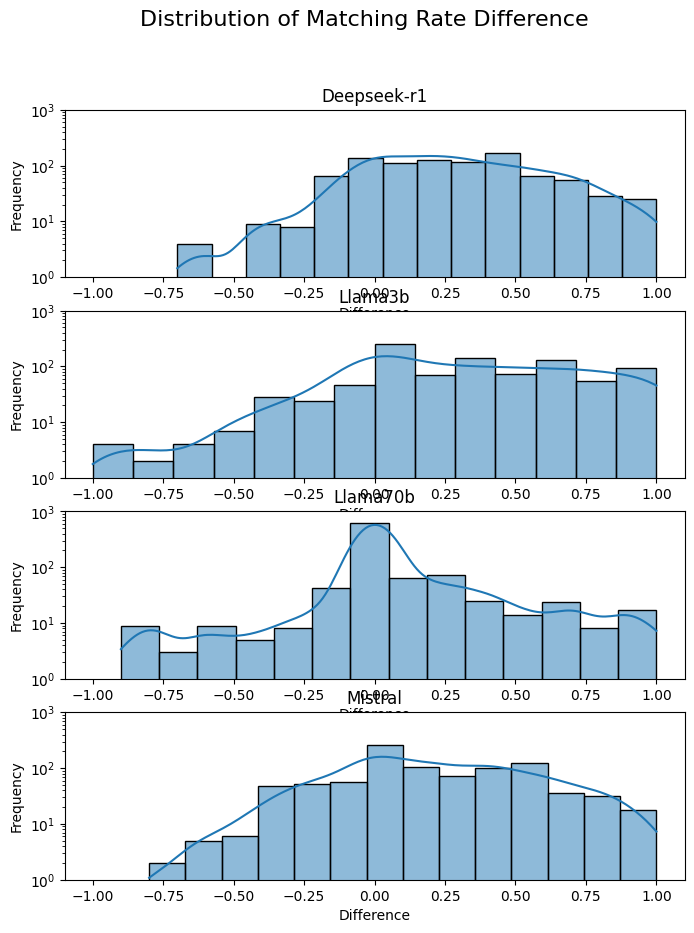

In [326]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(8, 10))
plt.suptitle("Distribution of Matching Rate Difference", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(4, 1, i)
    data_subset = df_related_hit_pivot[(df_related_hit_pivot["model"] == model)]
    data_subset = data_subset.groupby('title')['difference'].mean().reset_index()
    sns.histplot(data=data_subset, x="difference", bins=14, kde=True)
    plt.title(f"{model.capitalize()}")
    plt.ylim(1, 1000)  # Set the same y-axis limit
    plt.xlim(-1.1, 1.1)  # Set the same x-axis limit
    plt.xlabel("Difference")
    plt.yscale('log')
    plt.ylabel("Frequency")

In [296]:
df_change = df_pivot.groupby(["title", "model"])["difference"].mean().reset_index()
df_change

,title,model,difference
0,Accountants and Auditors,deepseek-r1,0.0
1,Accountants and Auditors,llama3b,0.0
2,Accountants and Auditors,llama70b,0.0
3,Accountants and Auditors,mistral,0.0
4,Actors,deepseek-r1,0.0
...,...,...,...
3687,Writers and Authors,mistral,0.0
3688,Zoologists and Wildlife Biologists,deepseek-r1,0.0
3689,Zoologists and Wildlife Biologists,llama3b,0.0
3690,Zoologists and Wildlife Biologists,llama70b,0.0


<Axes: xlabel='difference', ylabel='Count'>

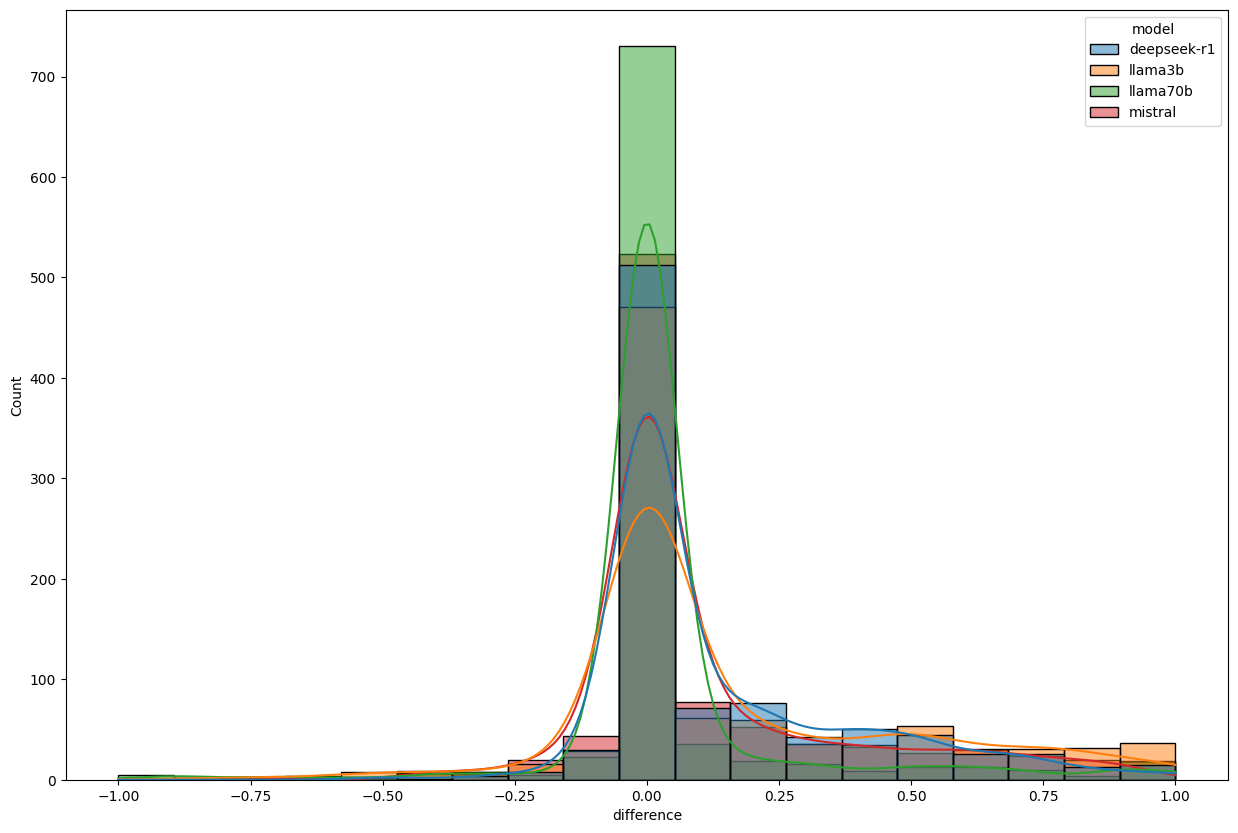

In [438]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df_change, x="difference", bins=19, kde=True, hue="model", alpha=0.5)

# plt.yscale('log')

looking at the change in matching rate for eaach jobs, most jobs didnt get a boost (0 match rate). more jobs gets a boost of matching rate, although some jobs perform poorer using persona than benchmark.

In [17]:
#get a df to show the average correct match rate by model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
avg_hits = avg_hits.pivot(index="model", columns="prompt", values="correct_match").reset_index()
avg_hits.columns.name = None  # Remove the name of the columns
avg_hits = avg_hits.rename(columns={"benchmark": "average_benchmark", "persona": "average_persona"})
avg_hits["difference"] = avg_hits["average_persona"] - avg_hits["average_benchmark"]
avg_hits["percentage_difference"] = (avg_hits["difference"] / avg_hits["average_benchmark"]) * 100
avg_hits = avg_hits.sort_values(by="percentage_difference", ascending=False)
avg_hits

,model,average_benchmark,average_persona,difference,percentage_difference
0,deepseek-r1,0.079198,0.218310,0.139112,175.649795
1,llama3b,0.153738,0.314735,0.160997,104.721635
3,mistral,0.111593,0.227736,0.116143,104.077670
2,llama70b,0.318635,0.362189,0.043554,13.668820


deepseek receives the largest boost. notably after the use of persona, llama 3b perform comparably to 70b model.

## correct match by industry and zone

In [225]:
df_pivot

prompt,title,area,zone,model,iteration,benchmark,persona,difference
0,Accountants and Auditors,13,4,deepseek-r1,0,0.0,0.0,0.0
1,Accountants and Auditors,13,4,deepseek-r1,1,0.0,0.0,0.0
2,Accountants and Auditors,13,4,deepseek-r1,2,0.0,0.0,0.0
3,Accountants and Auditors,13,4,deepseek-r1,3,0.0,0.0,0.0
4,Accountants and Auditors,13,4,deepseek-r1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36915,Zoologists and Wildlife Biologists,19,4,mistral,5,0.0,0.0,0.0
36916,Zoologists and Wildlife Biologists,19,4,mistral,6,0.0,0.0,0.0
36917,Zoologists and Wildlife Biologists,19,4,mistral,7,0.0,0.0,0.0
36918,Zoologists and Wildlife Biologists,19,4,mistral,8,0.0,0.0,0.0


In [253]:
df_area = df_related_hit_pivot[["model", "iteration", "area", "persona", "benchmark"]]
df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()
df_area

prompt,model,iteration,area,persona,benchmark
0,deepseek-r1,0,11,0.696429,0.482143
1,deepseek-r1,0,13,0.854167,0.250000
2,deepseek-r1,0,15,0.583333,0.305556
3,deepseek-r1,0,17,0.357143,0.107143
4,deepseek-r1,0,19,0.600000,0.250000
...,...,...,...,...,...
875,mistral,9,45,0.500000,0.500000
876,mistral,9,47,0.213115,0.327869
877,mistral,9,49,0.400000,0.300000
878,mistral,9,51,0.308411,0.140187


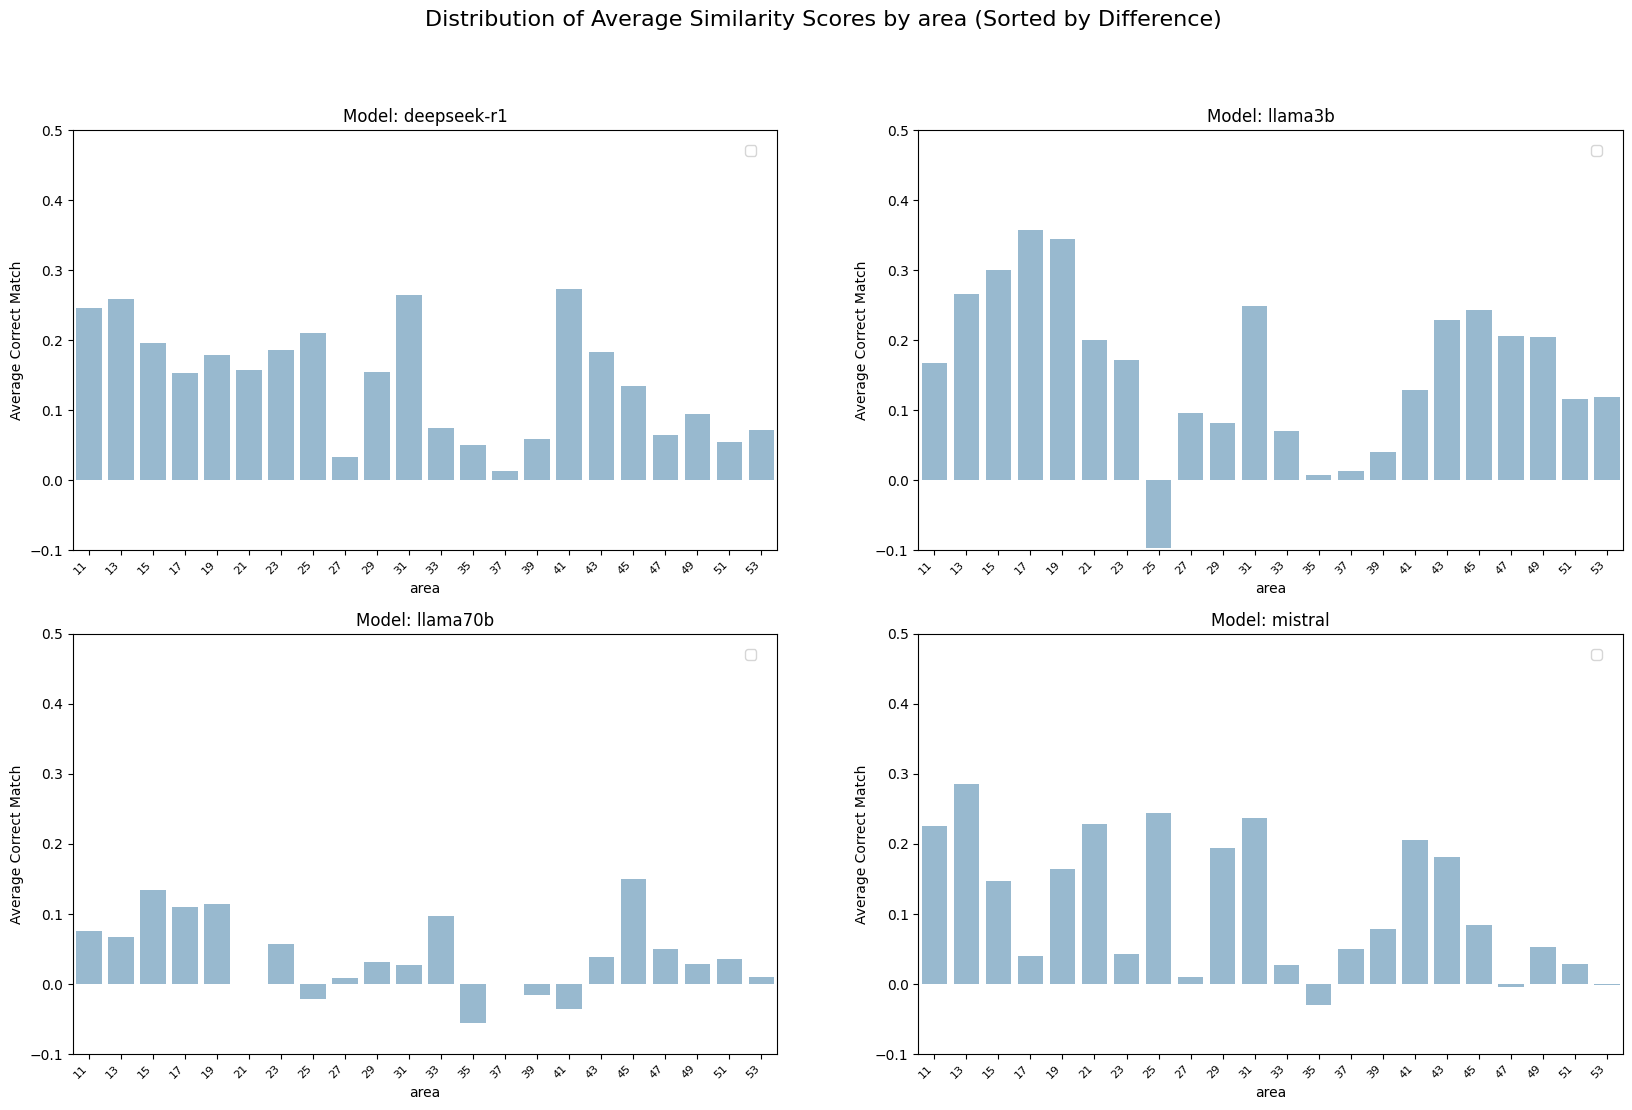

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
# df_pivot
# df_recall_pivot
df_area = df_pivot[["model", "iteration", "area", "persona", "benchmark"]]
df_area = df_area.groupby(["model", "iteration", "area"]).mean().reset_index()

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Similarity Scores by area (Sorted by Difference)", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area[df_area['model'] == model].copy()

    # Calculate the difference for sorting industries
    df_diff = df_model.groupby('area')[['benchmark', 'persona']].mean()
    # df_diff['average'] = (df_diff['persona'] + df_diff['benchmark']) / 2
    df_diff['average'] = df_diff['persona'] - df_diff['benchmark']
    df_diff_sorted = df_diff.sort_values(by='average', ascending=False).index

    # # Use the sorted order for the stripplot
    # sns.stripplot(x='area', y='benchmark', label='benchmark', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted, jitter=True)
    # sns.stripplot(x='area', y='persona', label='persona', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted, jitter=True)
    sns.barplot(data=df_diff, x="area", y="average", alpha=0.5)
  
    # # Melt the dataframe to long format for side-by-side bars
    # df_long = df_model.melt(id_vars=['area'], value_vars=['benchmark', 'persona'],
    #                         var_name='prompt', value_name='score')
    # sns.barplot(data=df_long, x="area", y="score", hue="prompt", order=df_diff_sorted, dodge=True)
    

    plt.title(f'Model: {model}')
    plt.xlabel('area')
    plt.ylabel('Average Correct Match')
    plt.ylim(-0.1, 0.5)  # Set the same y-axis limit
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[21:23], labels[21:23], loc='upper right', bbox_to_anchor=(0.98, 0.98))


plt.show()

In [437]:
df_diff

prompt,benchmark,persona,average
area,,,
11,0.141071,0.366071,0.225000
13,0.052083,0.337500,0.285417
15,0.033333,0.180556,0.147222
17,0.026786,0.066071,0.039286
19,0.093333,0.256667,0.163333
21,0.164286,0.392857,0.228571
23,0.042857,0.085714,0.042857
25,0.248387,0.491935,0.243548
27,0.147500,0.157500,0.010000


boost of persona shown in industry. on the right side, it shows that for some industries, persona prompt effect is not obvious, or even detrimental. 

In [21]:
import statsmodels.formula.api as smf
df_regression = df_pivot.groupby(["model", "title", "area"]).mean().reset_index().drop(columns=["iteration"])
df_regression['area'] = pd.Categorical(df_regression['area'])
df_regression['zone'] = pd.Categorical(df_regression['zone'])
df_regression = df_regression.melt(id_vars=['model', 'title', 'area', 'zone'],
                             value_vars=['benchmark', 'persona'],
                             var_name='prompt',
                             value_name='average_similarity_score')
df_regression = df_regression[df_regression['model'] == "mistral"].copy()
# Model the similarity score ('all_fit') as a function of prompt, area, job_zone, and their interactions
formula_with_prompt = 'average_similarity_score ~ C(prompt)'# * C(area)'
model_with_prompt = smf.ols(formula_with_prompt, data=df_regression)
results_with_prompt = model_with_prompt.fit()

print(results_with_prompt.summary())

                               OLS Regression Results                               
Dep. Variable:     average_similarity_score   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     80.97
Date:                      Mon, 26 May 2025   Prob (F-statistic):           5.56e-19
Time:                              13:19:50   Log-Likelihood:                -250.45
No. Observations:                      1846   AIC:                             504.9
Df Residuals:                          1844   BIC:                             516.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

above shows prompt has strong effect in increasing matching rate.

In [23]:
model = ["deepseek-r1"]
df_ind = df_avg[df_avg["model"] == model[0]].copy()
df_ind = df_ind.pivot_table(index=["area"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_ind["difference"] = df_ind["persona"] - df_ind["benchmark"]
df_ind = df_ind.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_ind["benchmark"] = df_ind["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_ind["persona"] = df_ind["persona"].apply(lambda x: "{:.2f}%".format(x))
df_ind["difference"] = df_ind["difference"].apply(lambda x: "{:.2f}%".format(x))
df_ind

prompt,area,benchmark,persona,difference
15,41,18.18%,45.45%,27.27%
10,31,23.68%,50.00%,26.32%
1,13,6.46%,32.29%,25.83%
0,11,18.21%,42.68%,24.46%
7,25,12.90%,33.87%,20.97%
2,15,6.67%,26.11%,19.44%
6,23,2.86%,21.43%,18.57%
16,43,8.04%,26.27%,18.24%
4,19,4.67%,22.50%,17.83%
5,21,21.43%,37.14%,15.71%


In [ ]:
df_mistral = df[df["model"] == "mistral"].copy()
df_mistral_reg = df_mistral[["title", "industry", "prompt", "related_recall", "zone"]]
df_mistral_reg

,title,industry,prompt,related_recall,zone
55380,Chief Executives,11,benchmark,0.4,5
55381,Chief Sustainability Officers,11,benchmark,0.0,5
55382,General and Operations Managers,11,benchmark,0.5,4
55383,Legislators,11,benchmark,0.0,4
55384,Advertising and Promotions Managers,11,benchmark,0.8,4
...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,53,persona,0.2,2
73836,"Pump Operators, Except Wellhead Pumpers",53,persona,0.0,2
73837,Wellhead Pumpers,53,persona,0.0,2
73838,Refuse and Recyclable Material Collectors,53,persona,0.0,2


In [ ]:
zone_industry_counts = pd.crosstab(df_mistral['industry'], df_mistral['zone']).div(10)
zone_industry_counts = zone_industry_counts.astype(int)
zone_industry_counts["sum"] = zone_industry_counts.sum(axis=1)
zone_industry_counts = zone_industry_counts.sort_values(by="sum", ascending=False)
zone_industry_counts

zone,1,2,3,4,5,sum
industry,,,,,,
51,14,162,38,0,0,214
29,0,0,56,18,104,178
25,0,0,14,26,84,124
47,16,84,22,0,0,122
19,0,0,22,40,58,120
11,0,6,14,78,14,112
17,0,2,28,74,8,112
53,2,78,20,4,0,104
43,0,72,26,4,0,102


not a signle industry contains jobs from all 5 zones. so some industry effect might be misinterpreted. thats why 2 regressions will be run, one with prompt x industry, andother is prompt x zone

for prompt x industry, 47 will be used a baseline because benchmark and persona difference is small, closer to average benchmark matching rate, and more frequent in the dataset.

C(prompt)[T.persona]                      -0.0605      0.201     -0.301      0.763      -0.454       0.333 \
persona effect in 47 is small and insignificant, which is expected.

In [ ]:
model = ["deepseek-r1"]
df_zone = df_avg[df_avg["model"] == model[0]].copy()
df_zone = df_zone.pivot_table(index=["zone"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_zone["difference"] = df_zone["persona"] - df_zone["benchmark"]
df_zone = df_zone.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_zone["benchmark"] = df_zone["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_zone["persona"] = df_zone["persona"].apply(lambda x: "{:.2f}%".format(x))
df_zone["difference"] = df_zone["difference"].apply(lambda x: "{:.2f}%".format(x))
df_zone

prompt,zone,benchmark,persona,difference
3,4,8.53%,28.93%,20.40%
4,5,8.38%,27.40%,19.03%
2,3,7.99%,19.41%,11.42%
1,2,7.05%,16.34%,9.29%
0,1,9.03%,12.26%,3.23%


In [ ]:
#find out the count of each zone
zone_counts = df_mistral["zone"].value_counts().div(20)
zone_counts = zone_counts.astype(int).reset_index()
zone_counts

,zone,count
0,2,295
1,4,224
2,3,219
3,5,154
4,1,31


C(prompt)[T.persona] shows with persona, it helps increase the log odds by 0.5453 and its significant. \
\
except zone 5, all other zone perform similarly without benchmark. log odds is small and insignificant. \
\
but after persona, zone 4 C(prompt)[T.persona]:C(zone)[T.4] and zone 5 benefit a lot from persona since log odds are high and significant.

The 'persona' prompt has a statistically significant positive effect on the likelihood of a correct match in the reference zone ('2').\
\
The 'persona' prompt also has a significantly more positive effect in Zone '4' and Zone '5' compared to the reference zone. This suggests that the 'persona' prompt is particularly beneficial in these zones.\
\
The effect of the 'persona' prompt in Zone '1' and Zone '3' is not significantly different from its effect in the reference zone.\
\
The baseline matching rates (with the 'benchmark' prompt) differ across zones, with Zone '5' having a significantly higher rate than the reference zone.\
\
more complex job is benefited by persona prompt more.

### Recall

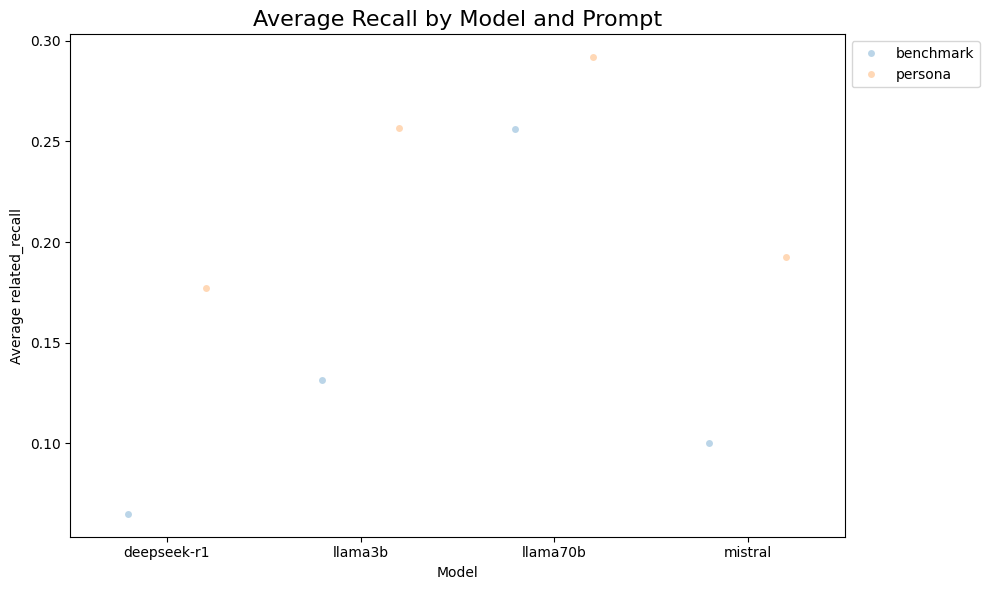

In [ ]:
# Calculate the average related_recall for each model and prompt
avg_hits = df.groupby(["model", "prompt"])["related_recall"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="related_recall", hue="prompt", bw_adjust=3)
sns.stripplot(data=avg_hits, x="model", y="related_recall", hue="prompt", dodge=True, 
              size=5, alpha=0.3, jitter=True)

# Add labels and title
plt.title("Average Recall by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average related_recall")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

# 2. Melt the DataFrame to long format for correct_match and related_match
df_both = df.drop(columns=['related_recall'])
df_both = df_both.melt(
    id_vars=[col for col in df_both.columns if col not in ['correct_match', 'related_match']],
    value_vars=['correct_match', 'related_match'],
    var_name='task',
    value_name='match'
).reset_index(drop=True)

df_both

,title,iteration,model,prompt,code,zone,industry,task,match
0,Chief Executives,0,deepseek-r1,benchmark,11-1011.00,5,11,correct_match,1
1,Chief Sustainability Officers,0,deepseek-r1,benchmark,11-1011.03,5,11,correct_match,1
2,General and Operations Managers,0,deepseek-r1,benchmark,11-1021.00,4,11,correct_match,0
3,Legislators,0,deepseek-r1,benchmark,11-1031.00,4,11,correct_match,0
4,Advertising and Promotions Managers,0,deepseek-r1,benchmark,11-2011.00,4,11,correct_match,0
...,...,...,...,...,...,...,...,...,...
147675,Gas Compressor and Gas Pumping Station Operators,9,mistral,persona,53-7071.00,2,53,related_match,1
147676,"Pump Operators, Except Wellhead Pumpers",9,mistral,persona,53-7072.00,2,53,related_match,0
147677,Wellhead Pumpers,9,mistral,persona,53-7073.00,2,53,related_match,0
147678,Refuse and Recyclable Material Collectors,9,mistral,persona,53-7081.00,2,53,related_match,0


## to find out reference group for each regression that is closest to average

In [ ]:
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="correct_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.079198,0.218310,0.139112
1,llama3b,0.153738,0.314735,0.160997
2,llama70b,0.318635,0.362189,0.043554
3,mistral,0.111593,0.227736,0.116143


In [ ]:
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["correct_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="correct_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]
df_ind_check

prompt,model,industry,benchmark,persona,difference
0,deepseek-r1,11,0.182143,0.426786,0.244643
1,deepseek-r1,13,0.064583,0.322917,0.258333
2,deepseek-r1,15,0.066667,0.261111,0.194444
3,deepseek-r1,17,0.010714,0.162500,0.151786
4,deepseek-r1,19,0.046667,0.225000,0.178333
...,...,...,...,...,...
83,mistral,45,0.083333,0.166667,0.083333
84,mistral,47,0.091803,0.086885,-0.004918
85,mistral,49,0.064000,0.116000,0.052000
86,mistral,51,0.038318,0.066355,0.028037


In [ ]:
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
9,deepseek-r1,29,0.085393,0.239326,0.153933,0.027211
38,llama3b,43,0.133333,0.360784,0.227451,0.066454
60,llama70b,43,0.368627,0.405882,0.037255,0.093686
80,mistral,39,0.132258,0.209677,0.077419,0.038724


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
2,deepseek-r1,3,0.079909,0.194064,0.114155,0.024956
7,llama3b,3,0.110046,0.290411,0.180365,0.068016
12,llama70b,3,0.269406,0.337443,0.068037,0.073974
17,mistral,3,0.103653,0.190411,0.086758,0.045264


Related Match

In [ ]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by industry
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["related_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="related_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

In [ ]:
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.267606,0.544420,0.276815
1,llama3b,0.392849,0.708992,0.316143
2,llama70b,0.690791,0.750271,0.059480
3,mistral,0.349512,0.553954,0.204442


In [ ]:
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
11,deepseek-r1,33,0.238462,0.507692,0.269231,0.065872
30,llama3b,27,0.452500,0.665000,0.212500,0.103643
52,llama70b,27,0.742500,0.735000,-0.007500,0.066980
80,mistral,39,0.429032,0.596774,0.167742,0.122339


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
3,deepseek-r1,4,0.085268,0.289286,0.204018,0.437472
9,llama3b,5,0.295455,0.396104,0.100649,0.410283
14,llama70b,5,0.490909,0.508442,0.017532,0.441711
19,mistral,5,0.165584,0.375974,0.210390,0.361909


related recall

In [ ]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_recall"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_recall").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by industry
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["related_recall"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="related_recall").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

In [ ]:
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.065038,0.177053,0.112015
1,llama3b,0.131528,0.256739,0.125211
2,llama70b,0.256078,0.291831,0.035753
3,mistral,0.100412,0.192752,0.092340


In [ ]:
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
2,deepseek-r1,15,0.062778,0.201389,0.138611,0.026596
38,llama3b,43,0.130000,0.289412,0.159412,0.034200
47,llama70b,17,0.236607,0.354821,0.118214,0.082461
80,mistral,39,0.104516,0.156774,0.052258,0.040082


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
1,deepseek-r1,2,0.070508,0.163390,0.092881,0.019134
7,llama3b,3,0.110046,0.290411,0.180365,0.055154
12,llama70b,3,0.269406,0.337443,0.068037,0.058940
17,mistral,3,0.103653,0.190411,0.086758,0.005582


In [ ]:
df.groupby(['industry', 'prompt'])['related_match'].value_counts(normalize=True)
#find only group with only persona
# df_industry = df.groupby(['industry', 'prompt'])['related_match'].value_counts(normalize=True).reset_index()
# df_industry[df_industry["proportion"] > 0.7]




industry  prompt     related_match
11        benchmark  1                0.618750
                     0                0.381250
          persona    1                0.865625
                     0                0.134375
13        benchmark  1                0.531771
                                        ...   
51        persona    1                0.335981
53        benchmark  0                0.790385
                     1                0.209615
          persona    0                0.636058
                     1                0.363942
Name: proportion, Length: 88, dtype: float64

In [ ]:
df_l70 = df[df["model"] == "llama70b"].copy()
df_ds = df[df["model"] == "deepseek-r1"].copy()
test = pd.crosstab(df_l70['correct_match'], [df_l70['prompt'], df_l70['zone']], normalize=False).transpose()
test



correct_match      0     1
prompt    zone            
benchmark 1      286    24
          2     2324   626
          3     1600   590
          4     1295   945
          5      784   756
persona   1      280    30
          2     2251   699
          3     1451   739
          4     1148  1092
          5      757   783

In [ ]:
# Exclude titles with average success rate < 0.05 or > 0.95
title_summary = df_l70.groupby('title')['correct_match'].agg(['sum', 'count']).reset_index()
title_summary['avg_success_rate'] = title_summary['sum'] / title_summary['count']
outlier_titles = title_summary[
    (title_summary['avg_success_rate'] < 0.01) | (title_summary['avg_success_rate'] >0.99)
]['title'].unique()
print(f"Excluding {len(outlier_titles)} titles with average success rate < 0.05 or > 0.95")
df_l70 = df_l70[~df_l70['title'].isin(outlier_titles)]

Excluding 728 titles with average success rate < 0.05 or > 0.95


In [ ]:
# Exclude titles with average success rate < 0.05 or > 0.95
title_summary = df_ds.groupby('title')['correct_match'].agg(['sum', 'count']).reset_index()
title_summary['avg_success_rate'] = title_summary['sum'] / title_summary['count']
outlier_titles = title_summary[
    (title_summary['avg_success_rate'] < 0.005) | (title_summary['avg_success_rate'] >0.995)
]['title'].unique()
print(f"Excluding {len(outlier_titles)} titles with average success rate < 0.05 or > 0.95")
df_ds = df_ds[~df_ds['title'].isin(outlier_titles)]

Excluding 459 titles with average success rate < 0.05 or > 0.95


In [ ]:
df_ds

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
18455,Gas Compressor and Gas Pumping Station Operators,9,0,0,0.0,deepseek-r1,persona,53-7071.00,2,53
18456,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,deepseek-r1,persona,53-7072.00,2,53
18457,Wellhead Pumpers,9,0,0,0.0,deepseek-r1,persona,53-7073.00,2,53
18458,Refuse and Recyclable Material Collectors,9,0,1,0.1,deepseek-r1,persona,53-7081.00,2,53


In [ ]:
#remove industry with values 17, 37, 45, 49
df_ds = df_ds[~df_ds['industry'].isin(["17", "37", "45", "49"])]

df_ds

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
18455,Gas Compressor and Gas Pumping Station Operators,9,0,0,0.0,deepseek-r1,persona,53-7071.00,2,53
18456,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,deepseek-r1,persona,53-7072.00,2,53
18457,Wellhead Pumpers,9,0,0,0.0,deepseek-r1,persona,53-7073.00,2,53
18458,Refuse and Recyclable Material Collectors,9,0,1,0.1,deepseek-r1,persona,53-7081.00,2,53


In [ ]:
# Assuming your DataFrame is named 'df_ds'
title_rates = df_ds.groupby(['prompt', 'industry', 'title'])['correct_match'].mean().reset_index(name='mean_correct_match')
title_rates["industry"].unique()

array(['11', '13', '15', '19', '21', '23', '25', '27', '29', '31', '33',
       '35', '39', '41', '43', '47', '51', '53'], dtype=object)

In [ ]:
def identify_outliers_by_group_iqr(df, group_cols, value_col, threshold=1.5):
    outlier_titles = set()
    grouped = df.groupby(group_cols)
    for name, group in grouped:
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = group[(group[value_col] < lower_bound) | (group[value_col] > upper_bound)]
        outlier_titles.update(outliers['title'].unique())
    return list(outlier_titles)

outlier_titles_to_exclude = identify_outliers_by_group_iqr(
    title_rates,
    ['prompt', 'industry'],
    'mean_correct_match',
    threshold=2  # You can adjust this threshold
)

print("Titles identified as outliers:", outlier_titles_to_exclude)

Titles identified as outliers: ['Fence Erectors', 'Nannies', 'Electromechanical Equipment Assemblers', 'Parking Enforcement Workers', 'Self-Enrichment Teachers', 'Labor Relations Specialists', 'School Bus Monitors', 'Helpers--Carpenters', 'Public Relations Specialists', 'Biomass Plant Technicians', 'Driver/Sales Workers', 'Printing Press Operators', 'First-Line Supervisors of Security Workers', 'Helpers--Roofers', 'Team Assemblers', 'Occupational Therapists', 'Model Makers, Wood', 'Industrial-Organizational Psychologists', 'Machinists', 'Solar Energy Installation Managers', 'Biofuels Processing Technicians', 'Potters, Manufacturing', 'Aviation Inspectors', 'Funeral Home Managers', 'Art Directors', 'Customer Service Representatives', 'Childcare Workers', 'First-Line Supervisors of Passenger Attendants', 'Actors', 'Patient Representatives', 'Fashion Designers', 'Tire Builders', 'Computer Numerically Controlled Tool Operators', 'Passenger Attendants', 'Transportation Security Screeners', 

In [ ]:
df_ds_filtered = df_ds[~df_ds['title'].isin(outlier_titles_to_exclude)]
print("Shape of original DataFrame:", df_ds.shape)
print("Shape of filtered DataFrame:", df_ds_filtered.shape)

Shape of original DataFrame: (15940, 10)
Shape of filtered DataFrame: (14300, 10)


In [ ]:
test = pd.crosstab(df_ds_filtered['correct_match'], [df_ds_filtered['prompt'], df_ds_filtered['industry']], normalize=False).transpose()
test

correct_match         0    1
prompt    industry          
benchmark 11        457   93
          13        439   21
          15        336   24
          19        562   18
          21        110   20
          23         59    1
          25        536   64
          27        309   21
          29        791   49
          31        145   45
          33        200    0
          35        120    0
          39        254   36
          41        180   40
          43        458   32
          47        490    0
          51        820    0
          53        420    0
persona   11        317  233
          13        317  143
          15        266   94
          19        446  134
          21         88   42
          23         54    6
          25        410  190
          27        310   20
          29        668  172
          31         95   95
          33        195    5
          35        111    9
          39        239   51
          41        120  100
          43        370  120
          47        469   21
          51        820    0
          53        406   14

In [ ]:
test = pd.crosstab(df_ds['correct_match'], [df_ds['prompt'], df_ds['industry']], normalize=False).transpose()
#add a column to the test to show  percentage difference between 1 and 0, sort descending
test["percentage_difference"] = (test[1] - test[0]) / test[0] * 100
test = test.sort_values(by="percentage_difference", ascending=False)
test

correct_match          0    1  percentage_difference
prompt    industry                                  
persona   31          95   95               0.000000
          41         120  100             -16.666667
          11         321  239             -25.545171
          21          88   52             -40.909091
          25         410  210             -48.780488
          13         325  155             -52.307692
          43         376  134             -64.361702
          15         266   94             -64.661654
          29         677  213             -68.537666
benchmark 31         145   45             -68.965517
persona   39         240   70             -70.833333
          19         465  135             -70.967742
benchmark 21         110   30             -72.727273
persona   23          55   15             -72.727273
          27         323   77             -76.160991
benchmark 11         458  102             -77.729258
          41         180   40             -77.777778
          39         258   52             -79.844961
persona   17         469   91             -80.597015
benchmark 27         336   64             -80.952381
persona   45         101   19             -81.188119
          35         135   25             -81.481481
benchmark 25         540   80             -85.185185
persona   33         230   30             -86.956522
          49         444   56             -87.387387
          47         545   65             -88.073394
benchmark 35         143   17             -88.111888
persona   53         468   52             -88.888889
benchmark 29         814   76             -90.663391
          43         469   41             -91.257996
persona   51         985   85             -91.370558
benchmark 15         336   24             -92.857143
          13         449   31             -93.095768
          19         572   28             -95.104895
          47         584   26             -95.547945
          33         249   11             -95.582329
persona   37          77    3             -96.103896
benchmark 53         505   15             -97.029703
          23          68    2             -97.058824
          51        1043   27             -97.411314
          45         117    3             -97.435897
          37          78    2             -97.435897
          49         491    9             -98.167006
          17         554    6             -98.916968

In [ ]:
df_ds_filtered["industry"].value_counts()

industry
51    2100
29    1680
25    1240
47    1180
19    1160
11    1120
53    1040
43    1020
17    1000
49    1000
13     920
27     800
15     720
39     600
33     480
41     440
31     380
35     320
21     280
45     220
37     160
23     140
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links

# --- Data Loading and Initial Preprocessing (from your original code) ---
# IMPORTANT: Replace this sample data with your actual data loading and preprocessing.
# Ensure 'df' DataFrame is structured with 'title', 'prompt', 'code', 'zone', 'industry',
# 'correct_match', and 'related_match' columns.
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess
llm = "deepseek-r1"
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy() # Ensure you're working on a copy to avoid warnings
df.drop(columns=['all_fit'], inplace=True, errors='ignore') # errors='ignore' if column might not exist
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

# Ensure 'code' exists and handle potential NaN after merge for 'industry'
df['industry'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')

# Categorical type and order
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['zone'] = df['zone'].astype(str) # Ensure zone is string for categorical
df['zone'] = pd.Categorical(df['zone'])

df['code_id'] = pd.Categorical(df['code']) # Use code as the unique identifier for groups

# Ensure 'industry' is categorical with a reference level
if '43' in df['industry'].unique():
    industry_categories = ['43'] + [cat for cat in df['industry'].unique() if cat != '43']
else:
    # Fallback: use the most frequent industry as reference if '43' isn't suitable
    most_frequent_industry = df['industry'].mode()[0]
    industry_categories = [most_frequent_industry] + [cat for cat in df['industry'].unique() if cat != most_frequent_industry]

df['industry'] = pd.Categorical(df['industry'], categories=industry_categories, ordered=False)

print("DataFrame head after critical preprocessing for GEE (Binary models):")
print(df[['prompt', 'zone', 'industry', 'code_id', 'correct_match', 'related_match']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- Helper Function for Running GEE Models (Binary Outcomes) ---
def run_binary_gee_model(dataframe, outcome_var, group_var, model_type_str):
    """
    Runs a GEE model for the specified binary outcome and prints a summary.
    Handles two separate models: one with prompt*industry and one with prompt*zone.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} ({model_type_str}) ---")

    link_instance = links.Logit() # Logit link for binary outcomes

    # Define common GEE parameters
    common_gee_params = {
        'data': dataframe,
        'groups': dataframe[group_var],
        'family': families.Binomial(link=link_instance),
        'cov_struct': cov_struct.Exchangeable()
    }

    # --- Model with prompt * industry interaction ---
    formula_industry = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C(industry)"
    print(f"Model 1 Formula: {formula_industry}")
    try:
        model_industry = smf.gee(formula_industry, **common_gee_params)
        results_industry = model_industry.fit()
        print(f"\n--- GEE Results: {outcome_var} ~ prompt * industry ---")
        print(results_industry.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_industry.params))
        print("\nP-values:")
        print(results_industry.pvalues)

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * industry): {e}")

    # --- Model with prompt * zone interaction ---
    formula_zone = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C(zone)"
    print(f"\nModel 2 Formula: {formula_zone}")
    try:
        model_zone = smf.gee(formula_zone, **common_gee_params)
        results_zone = model_zone.fit()
        print(f"\n--- GEE Results: {outcome_var} ~ prompt * zone ---")
        print(results_zone.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_zone.params))
        print("\nP-values:")
        print(results_zone.pvalues)

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * zone): {e}")


# --- Running the GEE Models for Binary Outcome Variables ---

# 1. Correct Match (Binary Outcome)
run_binary_gee_model(df,
                     outcome_var='correct_match',
                     group_var='code_id',
                     model_type_str='Binary')

# 2. Related Match (Binary Outcome)
run_binary_gee_model(df,
                     outcome_var='related_match',
                     group_var='code_id',
                     model_type_str='Binary')

DataFrame head after critical preprocessing for GEE (Binary models):
      prompt zone industry     code_id  correct_match  related_match
0  benchmark    5       11  11-1011.00              1              1
1  benchmark    5       11  11-1011.03              1              1
2  benchmark    4       11  11-1021.00              0              0
3  benchmark    4       11  11-1031.00              0              0
4  benchmark    4       11  11-2011.00              0              1
Number of unique code_id groups: 923

--- Running GEE Model for: correct_match (Binary) ---
Model 1 Formula: correct_match ~ C(prompt, Treatment(reference='benchmark')) * C(industry)

--- GEE Results: correct_match ~ prompt * industry ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                   

In [598]:
# run_recall_gee.py

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links

# --- Data Loading and Initial Preprocessing (from your original code) ---
# IMPORTANT: Replace this sample data with your actual data loading and preprocessing.
# Ensure 'df' DataFrame is structured with 'title', 'prompt', 'code', 'zone', 'industry',
# and 'related_recall' columns.
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess
llm = "mistral"
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy() # Ensure you're working on a copy to avoid warnings
df.drop(columns=['all_fit'], inplace=True, errors='ignore') # errors='ignore' if column might not exist
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)


try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

# Ensure 'code' exists and handle potential NaN after merge for 'industry'
df['industry'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan)
df['industry'].fillna('Unknown', inplace=True) # Fill NaN in industry after split if any
df['industry'] = df['industry'].astype(str) # Ensure industry is string type for get_dummies


# Categorical type and order for prompt and zone (unchanged)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['zone'] = df['zone'].astype(str) # Ensure zone is string for categorical
df['zone'] = pd.Categorical(df['zone'])

df['code_id'] = pd.Categorical(df['code']) # Use code as the unique identifier for groups

# --- Dynamically determine the reference industry ---
# Calculate the overall mean related recall proportion
overall_mean_recall = df['related_recall'].mean()
print(f"Overall Mean Related Recall: {overall_mean_recall:.4f}")

# Calculate mean related recall for each industry
industry_mean_recall = df.groupby('industry')['related_recall'].mean()
print("Mean Related Recall by Industry:")
print(industry_mean_recall.sort_values())

# Find the industry whose mean recall is closest to the overall mean
reference_industry = (industry_mean_recall - overall_mean_recall).abs().idxmin()
print(f"\nSelected Reference Industry (closest to overall mean): {reference_industry}")

# Reorder industry categories to set the chosen reference first
# Ensure all unique industries are included, with the reference at the beginning
all_industries = [reference_industry] + [cat for cat in df['industry'].unique() if cat != reference_industry]
df['industry'] = pd.Categorical(df['industry'], categories=all_industries, ordered=False)

df['zone'] = df['zone'].astype(str)

# --- Dynamically determine the reference ZONE ---
# Calculate mean related recall for each zone
zone_mean_recall = df.groupby('zone')['related_recall'].mean()
print("\nMean Related Recall by Zone:")
print(zone_mean_recall.sort_values())

# Find the zone whose mean recall is closest to the overall mean
reference_zone = (zone_mean_recall - overall_mean_recall).abs().idxmin()
print(f"\nSelected Reference Zone (closest to overall mean): {reference_zone}")

# Reorder zone categories to set the chosen reference first
# Ensure all unique zones are included, with the reference at the beginning
all_zones = [reference_zone] + [cat for cat in df['zone'].unique() if cat != reference_zone]
df['zone'] = pd.Categorical(df['zone'], categories=all_zones, ordered=False)

# --- Transform 'related_recall' into [successes, failures] 2D array ---
df['num_related_matches_count'] = (df['related_recall'] * 10).round().astype(int)
df['num_related_matches_failures'] = 10 - df['num_related_matches_count']


print("DataFrame head after critical preprocessing for GEE (Recall model):")
print(df[['prompt', 'zone', 'industry', 'code_id', 'num_related_matches_count', 'num_related_matches_failures']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


def run_recall_gee_model(dataframe, group_var, model_type_str, reference_industry_val, reference_zone_val): # Added reference_zone_val
    """
    Runs a GEE model for the specified proportional/count outcome and prints a summary.
    Handles two separate models: one with prompt*industry and one with prompt*zone.
    reference_industry_val: The dynamically chosen industry category to be used as reference.
    reference_zone_val: The dynamically chosen zone category to be used as reference. # New
    """
    endog_data = dataframe[['num_related_matches_count', 'num_related_matches_failures']].to_numpy()
    print(f"\n--- Running GEE Model for: Related Recall ({model_type_str}) ---")
    link_instance = links.Logit()

    # --- Model with prompt * industry interaction ---
    print(f"Model 1 Formula (derived): Intercept + prompt_persona + industry_dummies + interactions")
    try:
        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        industry_dummies_all = pd.get_dummies(dataframe['industry'], prefix='industry')
        reference_industry_col = 'industry_' + str(reference_industry_val)
        industry_dummies = industry_dummies_all.drop(columns=[reference_industry_col], errors='ignore')

        exog_base_industry = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base_industry = pd.concat([exog_base_industry, prompt_dummies, industry_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col_industry in industry_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col_industry}"
                exog_base_industry[interaction_col_name] = prompt_dummies['prompt_persona'] * industry_dummies[col_industry]

        exog_industry = exog_base_industry.astype(float)

        model_industry = sm.GEE(
            endog=endog_data,
            exog=exog_industry,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable()
        )
        results_industry = model_industry.fit()
        print(f"\n--- GEE Results: Related Recall ~ prompt * industry (Reference: {reference_industry_val}) ---")
        print(results_industry.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_industry.params))
        print("\nP-values:")
        print(results_industry.pvalues)

    except Exception as e:
        print(f"Error fitting model for Related Recall (prompt * industry): {e}")

    # --- Model with prompt * zone interaction ---
    print(f"\nModel 2 Formula (derived): Intercept + prompt_persona + zone_dummies + interactions")
    try:
        # Changed: Use the reference_zone_val passed to the function
        zone_dummies_all = pd.get_dummies(dataframe['zone'], prefix='zone')
        reference_zone_col = 'zone_' + str(reference_zone_val) # Use passed reference
        zone_dummies = zone_dummies_all.drop(columns=[reference_zone_col], errors='ignore')

        exog_base_zone = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base_zone = pd.concat([exog_base_zone, prompt_dummies, zone_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col_zone in zone_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col_zone}"
                exog_base_zone[interaction_col_name] = prompt_dummies['prompt_persona'] * zone_dummies[col_zone]

        exog_zone = exog_base_zone.astype(float)

        model_zone = sm.GEE(
            endog=endog_data,
            exog=exog_zone,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable()
        )
        results_zone = model_zone.fit()
        print(f"\n--- GEE Results: Related Recall ~ prompt * zone (Reference: {reference_zone_val}) ---") # Changed here too
        print(results_zone.summary())
        print("\nExponentiated Coefficients (Odds Ratios):")
        print(np.exp(results_zone.params))
        print("\nP-values:")
        print(results_zone.pvalues)

    except Exception as e:
        print(f"Error fitting model for Related Recall (prompt * zone): {e}")


# --- Running the GEE Models for Recall Outcome Variable ---
# Pass the dynamically chosen reference_industry AND reference_zone to the helper function
run_recall_gee_model(df,
                     group_var='code_id',
                     model_type_str='Proportional (Binomial GEE)',
                     reference_industry_val=reference_industry,
                     reference_zone_val=reference_zone) # New argument

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\2025377101.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['industry'].fillna('Unknown', inplace=True) # Fill NaN in industry after split if any


Overall Mean Related Recall: 0.1466
Mean Related Recall by Industry:
industry
51    0.038411
17    0.044643
53    0.049038
47    0.057869
33    0.058269
45    0.060000
37    0.063125
15    0.075972
49    0.083300
23    0.088571
35    0.099375
27    0.129875
39    0.130645
19    0.155083
13    0.187188
43    0.199412
11    0.215089
41    0.227045
29    0.269270
31    0.306053
25    0.344597
21    0.347500
Name: related_recall, dtype: float64

Selected Reference Industry (closest to overall mean): 19

Mean Related Recall by Zone:
zone
1    0.058226
2    0.094932
3    0.120297
4    0.171518
5    0.264416
Name: related_recall, dtype: float64

Selected Reference Zone (closest to overall mean): 4
DataFrame head after critical preprocessing for GEE (Recall model):
      prompt zone industry     code_id  num_related_matches_count  \
0  benchmark    5       11  11-1011.00                          4   
1  benchmark    5       11  11-1011.03                          0   
2  benchmark    4       1

In [639]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
llm = "llama3b"  # Change this to the desired model
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df['prompt'] = df['prompt'].astype('category')
df = df[df['model'] == llm].copy()
df.drop(columns=['all_fit'], inplace=True, errors='ignore')
df.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df = df.merge(occupation, on='title', how='left')
df = df.merge(zone, on='title', how='left')

df['industry'] = df['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df['trials'] = 1

# --- DIAGNOSE PERFECT SEPARATION ---
print("\n--- Diagnosing potential Perfect Separation for related_recall ---")
for p in df['prompt'].unique():
    for i in df['industry'].unique():
        subset = df[(df['prompt'] == p) & (df['industry'] == i)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', industry='{i}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', industry='{i}' (n={len(subset)})")
    for z in df['zone'].unique():
        subset = df[(df['prompt'] == p) & (df['zone'] == z)]
        if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
            print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
        if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
            print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
print("--- End Diagnosis ---")


# --- APPLY DATA JITTERING / SMOOTHING FOR RELATED_RECALL ---
df['related_recall_smoothed'] = df['related_recall'].copy().astype(float)
df['trials_smoothed'] = df['trials'].copy().astype(float)

# mask_zero = (df['related_recall_smoothed'] == 0)
# mask_full = (df['related_recall_smoothed'] == df['trials_smoothed'])

# df.loc[mask_zero, 'related_recall_smoothed'] += 0.5
# df.loc[mask_zero, 'trials_smoothed'] += 1.0

# df.loc[mask_full, 'related_recall_smoothed'] -= 0.5
# df.loc[mask_full, 'trials_smoothed'] += 1.0

df['num_related_matches_failures_smoothed'] = df['trials_smoothed'] - df['related_recall_smoothed']


# Ensure 'industry' and 'zone' are categorical before reference selection
df['industry'] = df['industry'].astype('category')
df['zone'] = df['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code_id'
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=False)
df['code_id'] = pd.Categorical(df['code'])

print("\nDataFrame head after critical preprocessing for GEE (with smoothed recall):")
print(df[['prompt', 'zone', 'industry', 'code_id', 'correct_match', 'related_match', 'related_recall', 'trials', 'related_recall_smoothed', 'trials_smoothed', 'num_related_matches_failures_smoothed']].head())
print(f"Number of unique code_id groups: {df['code_id'].nunique()}")


# --- NEW HELPER FUNCTION: Dynamically determine the reference category ---
def get_reference_category(dataframe, category_col, outcome_col, trials_col=None):
    """
    Determines the reference category for a given outcome and categorical column.
    The reference category is the one whose mean outcome is closest to the overall mean outcome.
    """
    if trials_col: # For proportional outcomes like related_recall_smoothed
        overall_mean = (dataframe[outcome_col] / dataframe[trials_col]).mean()
        category_means = dataframe.groupby(category_col).apply(lambda x: (x[outcome_col] / x[trials_col]).mean())
    else: # For binary outcomes like correct_match, related_match
        overall_mean = dataframe[outcome_col].mean()
        category_means = dataframe.groupby(category_col)[outcome_col].mean()
    
    # Ensure category_means is not empty, if so, return first category
    if category_means.empty:
        print(f"Warning: No data to determine reference category for {category_col} with {outcome_col}. Using first unique category.")
        return dataframe[category_col].unique()[0]

    reference_category = (category_means - overall_mean).abs().idxmin()
    print(f"Selected Reference {category_col} for {outcome_col}: {reference_category} (mean {category_means.loc[reference_category]:.4f}, overall mean {overall_mean:.4f})")
    return reference_category


# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_and_plot_odds_ratios(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) ---")

    link_instance = links.Logit()
    
    if outcome_var == 'related_recall_smoothed':
        endog_data = dataframe[['related_recall_smoothed', 'num_related_matches_failures_smoothed']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        # Determine current interaction type prefix for dummies
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix
        }
    else: # correct_match, related_match (binary) - use smf.gee as before
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '' # Not needed for smf.gee interaction coef names
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall_smoothed':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")


        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist()
        
        # Ensure the reference category is the first one in the list for consistent iteration
        # Remove the reference category if it exists in the original list, then prepend it
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories


        # Get the main effect coefficient for 'persona'
        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        # Get the variance for the main effect
        if persona_main_coef_name in results.cov_params().index and persona_main_coef_name in results.cov_params().columns:
            var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name]
        else:
            var_persona_main = 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                # Construct interaction coefficient name dynamically based on API
                if outcome_var == 'related_recall_smoothed': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" # No closing ')' because it's part of the base prefix

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None


# --- Store all OR results ---
all_or_results = []
all_reference_categories = {} # To store all dynamically chosen references for plotting

# --- Running the GEE Models for All Outcome Variables ---
for outcome in ['correct_match', 'related_match', 'related_recall_smoothed']:
    
    # --- Dynamically determine references for the CURRENT OUTCOME ---
    current_reference_industry = get_reference_category(
        df, 'industry', outcome, 
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    current_reference_zone = get_reference_category(
        df, 'zone', outcome,
        trials_col='trials_smoothed' if outcome == 'related_recall_smoothed' else None
    )
    
    # Store for plotting later to maintain consistent order
    all_reference_categories[outcome + '_industry'] = current_reference_industry
    all_reference_categories[outcome + '_zone'] = current_reference_zone

    # Industry interaction
    # Pass the outcome-specific reference to the function
    industry_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'industry', llm, current_reference_industry)
    if not industry_or_df.empty:
        all_or_results.append(industry_or_df)

    # Zone interaction
    # Pass the outcome-specific reference to the function
    zone_or_df, _ = calculate_and_plot_odds_ratios(df, outcome, 'code_id', 'zone', llm, current_reference_zone)
    if not zone_or_df.empty:
        all_or_results.append(zone_or_df)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting ---")
    print(final_or_df.head())
    final_or_df['metric'] = final_or_df['metric'].replace('related_recall_smoothed', 'related_recall')
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()





--- Diagnosing potential Perfect Separation for related_recall ---
--- End Diagnosis ---

DataFrame head after critical preprocessing for GEE (with smoothed recall):
      prompt zone industry     code_id  correct_match  related_match  \
0  benchmark    5       11  11-1011.00              1              1   
1  benchmark    5       11  11-1011.03              0              0   
2  benchmark    4       11  11-1021.00              0              0   
3  benchmark    4       11  11-1031.00              0              0   
4  benchmark    4       11  11-2011.00              0              1   

   related_recall  trials  related_recall_smoothed  trials_smoothed  \
0             0.6       1                      0.6              1.0   
1             0.0       1                      0.0              1.0   
2             0.0       1                      0.0              1.0   
3             0.0       1                      0.0              1.0   
4             0.3       1                    

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = dataframe.groupby(category_col)[outcome_col].mean()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = dataframe.groupby(category_col)[outcome_col].mean()



--- GEE Results Summary for correct_match ~ prompt * industry ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Sat, 31 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:31:15
                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = dataframe.groupby(category_col)[outcome_col].mean()
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = dataframe.groupby(category_col)[outcome_col].mean()



--- GEE Results Summary for related_match ~ prompt * industry ---
                               GEE Regression Results                              
Dep. Variable:               related_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                    11
Date:                     Sat, 31 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:31:18
                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------

c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:238: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt(combined_vcov)



--- GEE Results Summary for related_match ~ prompt * zone ---
                               GEE Regression Results                              
Dep. Variable:               related_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Sat, 31 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:31:18
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------

C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = dataframe.groupby(category_col).apply(lambda x: (x[outcome_col] / x[trials_col]).mean())
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_means = dataframe.groupby(category_col).apply(lambda x: (x[outcome_col] / x[trials_col]).mean())
C:\Users\godfr\AppData\Local\Temp\ipykernel_22120\4081076873.py:110: Fu


--- GEE Results Summary for related_recall_smoothed ~ prompt * industry ---
                               GEE Regression Results                              
Dep. Variable:                ['y1', 'y2']   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Sat, 31 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         00:31:18
                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

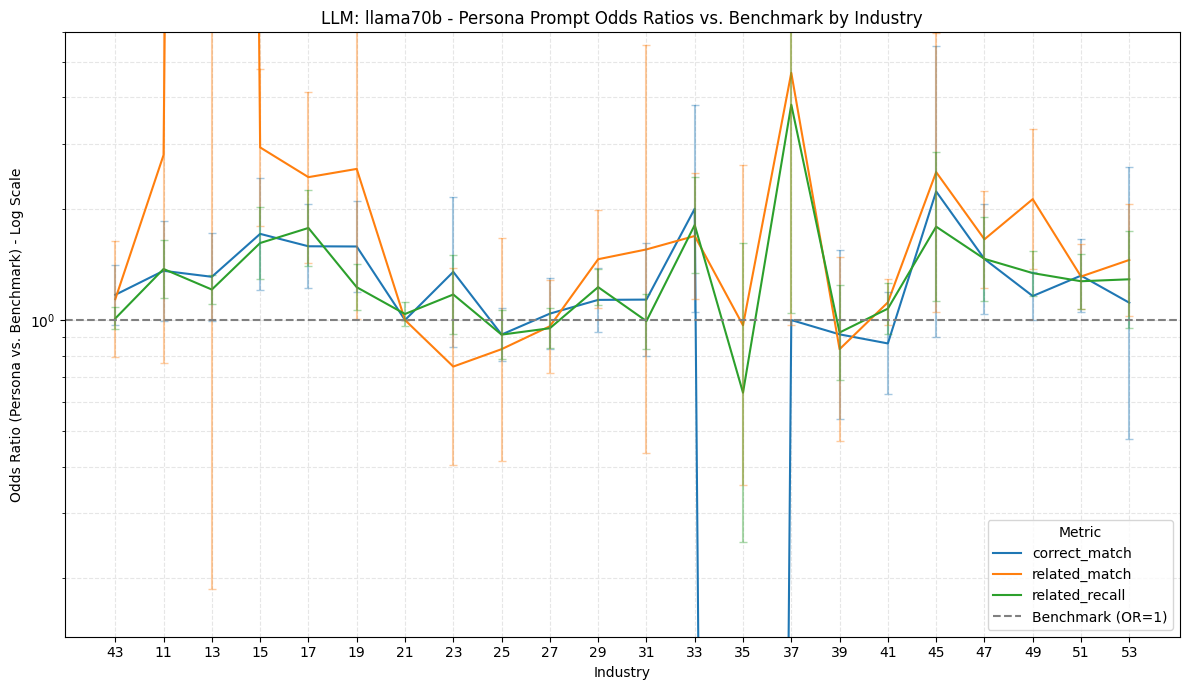

8.013385670543978e+29


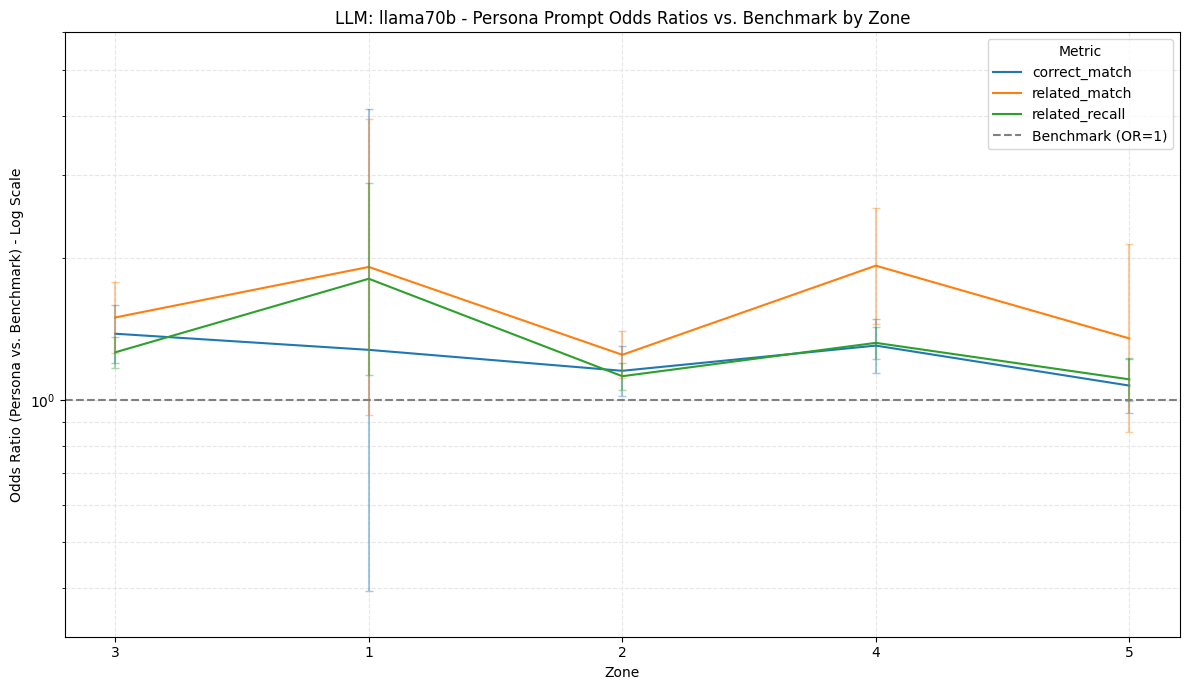

4.134393164566099


In [622]:
# --- Plotting the Odds Ratios ---
if not final_or_df.empty:
    for interaction_type in ['industry', 'zone']:
        plot_df = final_or_df[final_or_df[interaction_type].notna()].copy()

        # To ensure consistent plotting order, we need to order the categories based on the specific reference
        # that was used for each outcome.
        
        # Get all unique metrics in the plot_df for this interaction_type
        metrics_in_plot = plot_df['metric'].unique()
        
        # Create a combined list of categories respecting the chosen reference for each metric
        ordered_categories = []
        for metric in metrics_in_plot:
            # Reconstruct the key to get the stored reference
            ref_key = f"{metric}_smoothed_{interaction_type}" if metric == 'related_recall' else f"{metric}_{interaction_type}"
            current_reference_for_plotting = all_reference_categories.get(ref_key, None)

            if current_reference_for_plotting:
                # Get all unique categories for this interaction type (e.g., all industries)
                all_cats_for_type = df[interaction_type].cat.categories.tolist()
                
                # Remove the reference category if it's not already the first
                if current_reference_for_plotting in all_cats_for_type:
                    all_cats_for_type.remove(current_reference_for_plotting)
                
                # Prepend the reference category to ensure it's first
                ordered_list_for_metric = [current_reference_for_plotting] + all_cats_for_type
                
                # Add to the overall ordered_categories, ensuring uniqueness and order
                for cat in ordered_list_for_metric:
                    if cat not in ordered_categories:
                        ordered_categories.append(cat)
            else:
                # Fallback if reference not found (shouldn't happen with proper storage)
                print(f"Warning: Reference for {metric} and {interaction_type} not found for plotting order.")
                ordered_categories.extend([cat for cat in plot_df[interaction_type].unique() if cat not in ordered_categories])

        # Apply the determined order for plotting
        plot_df[interaction_type] = pd.Categorical(plot_df[interaction_type], categories=ordered_categories, ordered=True)
        plot_df.sort_values(by=[interaction_type, 'metric'], inplace=True) # Sort by interaction type and then metric

        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=plot_df,
            x=interaction_type,
            y='odds_ratio',
            hue='metric',
            errorbar=None,
            # marker='o',
            
        )

        # Plot confidence intervals manually
        metrics_for_plotting = plot_df['metric'].unique().tolist() # Get unique metrics in the current plot_df
        for i, metric in enumerate(metrics_for_plotting):
            subset = plot_df[plot_df['metric'] == metric].sort_values(by=interaction_type)
            
            # Ensure proper alignment for error bars
            # Convert categorical positions to numerical for errorbar
            x_positions = [plot_df[interaction_type].cat.categories.get_loc(cat) for cat in subset[interaction_type]]

            plt.errorbar(
                x=x_positions,
                y=subset['odds_ratio'],
                yerr=[subset['odds_ratio'] - subset['ci_lower'], subset['ci_upper'] - subset['odds_ratio']],
                fmt='none',
                capsize=3,
                alpha=0.4,
                color=sns.color_palette()[i] # Match line color using index
            )
            # Add text labels for x-axis ticks
            plt.xticks(ticks=range(len(ordered_categories)), labels=ordered_categories)


        plt.axhline(1, color='gray', linestyle='--', linewidth=1.5, label='Benchmark (OR=1)')
        plt.yscale('log')
        min_or = plot_df['ci_lower'].min()
        max_or = plot_df['ci_upper'].max()
        plt.ylim(max(0.1, min_or * 0.8),6)# max_or * 1.2 if max_or * 1.2 > 1.5 else 1.5)
        # plt.ylim(0.16, 50)
        

        plt.title(f'LLM: {llm} - Persona Prompt Odds Ratios vs. Benchmark by {interaction_type.capitalize()}')
        plt.xlabel(interaction_type.capitalize())
        plt.ylabel('Odds Ratio (Persona vs. Benchmark) - Log Scale')
        plt.legend(title='Metric')
        plt.grid(True, which="both", ls="--", c='.9')
        plt.tight_layout()
        plt.show()
        print(max_or)
else:
    print("\nSkipping plotting as no data was generated.")

In [635]:
df

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry,trials,related_recall_smoothed,trials_smoothed,num_related_matches_failures_smoothed,code_id,successes,failures
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11,1,0.5,1.0,0.5,11-1011.00,0.5,0.5
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11,1,0.1,1.0,0.9,11-1011.03,0.1,0.9
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11,1,0.0,1.0,1.0,11-1021.00,0.0,1.0
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11,1,0.0,1.0,1.0,11-1031.00,0.0,1.0
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11,1,0.9,1.0,0.1,11-2011.00,0.9,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18455,Gas Compressor and Gas Pumping Station Operators,9,0,0,0.0,deepseek-r1,persona,53-7071.00,2,53,1,0.0,1.0,1.0,53-7071.00,0.0,1.0
18456,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,deepseek-r1,persona,53-7072.00,2,53,1,0.0,1.0,1.0,53-7072.00,0.0,1.0
18457,Wellhead Pumpers,9,0,0,0.0,deepseek-r1,persona,53-7073.00,2,53,1,0.0,1.0,1.0,53-7073.00,0.0,1.0
18458,Refuse and Recyclable Material Collectors,9,0,1,0.1,deepseek-r1,persona,53-7081.00,2,53,1,0.1,1.0,0.9,53-7081.00,0.1,0.9


--- GEE Results: Related Recall ~ prompt * zone ---
                                 GEE Regression Results                                 
Dep. Variable:        ['successes', 'failures']   No. Observations:                18460
Model:                                      GEE   No. clusters:                      923
Method:                             Generalized   Min. cluster size:                  20
                           Estimating Equations   Max. cluster size:                  20
Family:                                Binomial   Mean cluster size:                20.0
Dependence structure:              Independence   Num. iterations:                     2
Date:                          Sat, 31 May 2025   Scale:                           1.000
Covariance type:                         robust   Time:                         00:31:31
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------

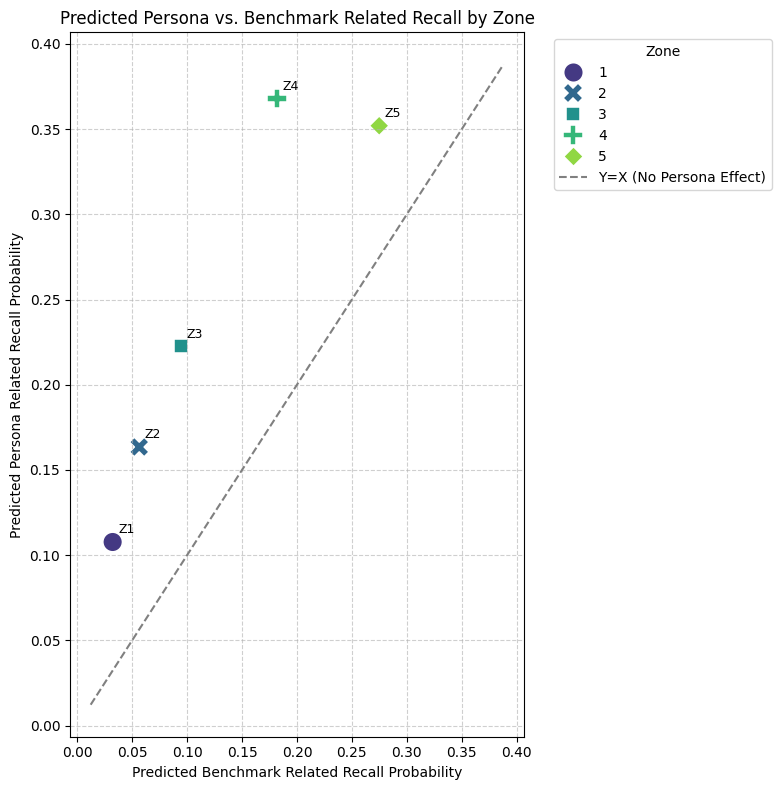


Predicted Probabilities by Zone and Prompt (for Plotting):
  zone  benchmark   persona
0    1   0.032258  0.107742
1    2   0.056475  0.163492
2    3   0.094429  0.222603
3    4   0.181830  0.368036
4    5   0.274870  0.352013


In [640]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy
import seaborn as sns

# Assuming 'df' is your DataFrame containing 'prompt', 'zone', 'related_recall', 'trials', 'code_id'
# And 'df_filtered_llm' is the subset for the specific LLM you used (e.g., 'mistral')
# Let's recreate a dummy df for demonstration purposes if you don't have it loaded.
# In a real scenario, you'd load your actual df and filter it.

# # --- Dummy Data Creation (Replace with your actual data loading and filtering) ---
# # This dummy data aims to mimic the structure and the average rates you've observed.
# np.random.seed(42)
# n_clusters = 923
# cluster_size = 20
# total_obs = n_clusters * cluster_size
# zones = [1, 2, 3, 4, 5]
# prompts = ['benchmark', 'persona']

# data = {
#     'code_id': np.repeat(np.arange(n_clusters), cluster_size),
#     'zone': np.random.choice(zones, total_obs),
#     'prompt': np.random.choice(prompts, total_obs),
#     'trials': 10, # Assuming 10 trials for related_recall
#     'related_recall': 0 # Placeholder, will be filled based on probabilities
# }
# df = pd.DataFrame(data)

# # Simulate related_recall based on approximate probabilities from your raw data
# # (Zone 5 benchmark ~0.175, persona ~0.354, others varied)
# # This part is just for dummy data to make plots look somewhat realistic.
# # Your actual model will use your real 'related_recall' data.
# zone_probs_benchmark = {1: 0.10, 2: 0.12, 3: 0.15, 4: 0.18, 5: 0.20} # Slightly adjusted for spread
# zone_probs_persona_multiplier = {1: 1.5, 2: 1.8, 3: 2.0, 4: 2.5, 5: 2.7} # Persona generally higher

# df['prob'] = df.apply(lambda row:
#                       zone_probs_benchmark[row['zone']] * (
#                           zone_probs_persona_multiplier[row['zone']] if row['prompt'] == 'persona' else 1
#                       ), axis=1)
# # Ensure probs don't exceed 1
# df['prob'] = np.clip(df['prob'], 0.05, 0.95) # Clip to avoid 0/1 after random generation

# df['related_recall'] = df.apply(lambda row: np.random.binomial(row['trials'], row['prob']), axis=1)

# Ensure 'related_recall' is count (0-10) and 'trials' is total (10)
# Make sure your actual df for modeling has these as counts
df['successes'] = df['related_recall']
df['failures'] = df['trials'] - df['related_recall']
# --- End Dummy Data Creation ---


model_formula_recall = 'successes + failures ~ C(prompt, Treatment(reference="benchmark")) + C(zone) + C(prompt, Treatment(reference="benchmark")):C(zone)'
group_var = 'code_id' # Your cluster variable

gee_model_recall = smf.gee(
    model_formula_recall,
    data=df, # Use your actual filtered df here
    groups=df[group_var],
    family=sm.families.Binomial(),
    cov_type='robust',
    # scale=None # Uncomment if you explicitly use scale=None in your actual model
)
gee_results_recall = gee_model_recall.fit()

print("--- GEE Results: Related Recall ~ prompt * zone ---")
print(gee_results_recall.summary()) # To see the model summary for confirmation

# --- Generate Predictions for Plotting (CORRECTED) ---
# Create a DataFrame for prediction based on unique zones and prompts
all_zones = sorted(df['zone'].unique()) # Get all unique zones from original data
all_prompts = ['benchmark', 'persona']

predict_df = pd.DataFrame([(z, p) for z in all_zones for p in all_prompts], columns=['zone', 'prompt'])
predict_df['trials'] = 10 # Needed for prediction context

# Use patsy.dmatrix to correctly generate the design matrix, matching model's internal structure
# The formula here should exclude the dependent variable part ('successes + failures ~')
formula_for_dmatrix = 'C(prompt, Treatment(reference="benchmark")) + C(zone) + C(prompt, Treatment(reference="benchmark")):C(zone)'

design_matrix = patsy.dmatrix(
    formula_for_dmatrix,
    data=predict_df,
    return_type='dataframe'
)

# Align columns of the generated design_matrix with the order of coefficients in the fitted model.
# This is crucial for correctly multiplying the design matrix by the coefficients.
# We ensure all columns present in model.params are in our design_matrix, filling missing with 0s.
# And drop any columns in design_matrix not present in model.params.
params = gee_results_recall.params
aligned_design_matrix = pd.DataFrame(0, index=design_matrix.index, columns=params.index)
for col in aligned_design_matrix.columns:
    if col in design_matrix.columns:
        aligned_design_matrix[col] = design_matrix[col]

# Calculate linear predictor (log-odds) using the aligned design matrix
linear_predictor = aligned_design_matrix.dot(params)

# Convert log-odds to probabilities using the inverse logit (sigmoid) function
predicted_probs = 1 / (1 + np.exp(-linear_predictor))

predict_df['predicted_prob'] = predicted_probs

# Pivot the DataFrame to get benchmark and persona probabilities side-by-side for plotting
plot_df = predict_df.pivot(index='zone', columns='prompt', values='predicted_prob').reset_index()
plot_df.columns.name = None # Remove column name for cleaner access

# --- Plotting ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x='benchmark', y='persona', data=plot_df, hue='zone', s=200, style='zone', markers=True, legend='full', palette='viridis')

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.text(row['benchmark'] + 0.005, row['persona'] + 0.005, f'Z{row["zone"]}', fontsize=9)

# Add a Y=X line for comparison (where persona effect would be zero on probability scale)
x_vals = np.linspace(min(plot_df['benchmark'].min(), plot_df['persona'].min()) - 0.02,
                     max(plot_df['benchmark'].max(), plot_df['persona'].max()) + 0.02, 100)
plt.plot(x_vals, x_vals, color='gray', linestyle='--', label='Y=X (No Persona Effect)')

plt.title('Predicted Persona vs. Benchmark Related Recall by Zone')
plt.xlabel('Predicted Benchmark Related Recall Probability')
plt.ylabel('Predicted Persona Related Recall Probability')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nPredicted Probabilities by Zone and Prompt (for Plotting):")
print(plot_df)


--- GEE Results: Related Recall ~ prompt * industry ---
                                 GEE Regression Results                                 
Dep. Variable:        ['successes', 'failures']   No. Observations:                18460
Model:                                      GEE   No. clusters:                      923
Method:                             Generalized   Min. cluster size:                  20
                           Estimating Equations   Max. cluster size:                  20
Family:                                Binomial   Mean cluster size:                20.0
Dependence structure:              Independence   Num. iterations:                     2
Date:                          Sat, 31 May 2025   Scale:                           1.000
Covariance type:                         robust   Time:                         00:31:38
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-

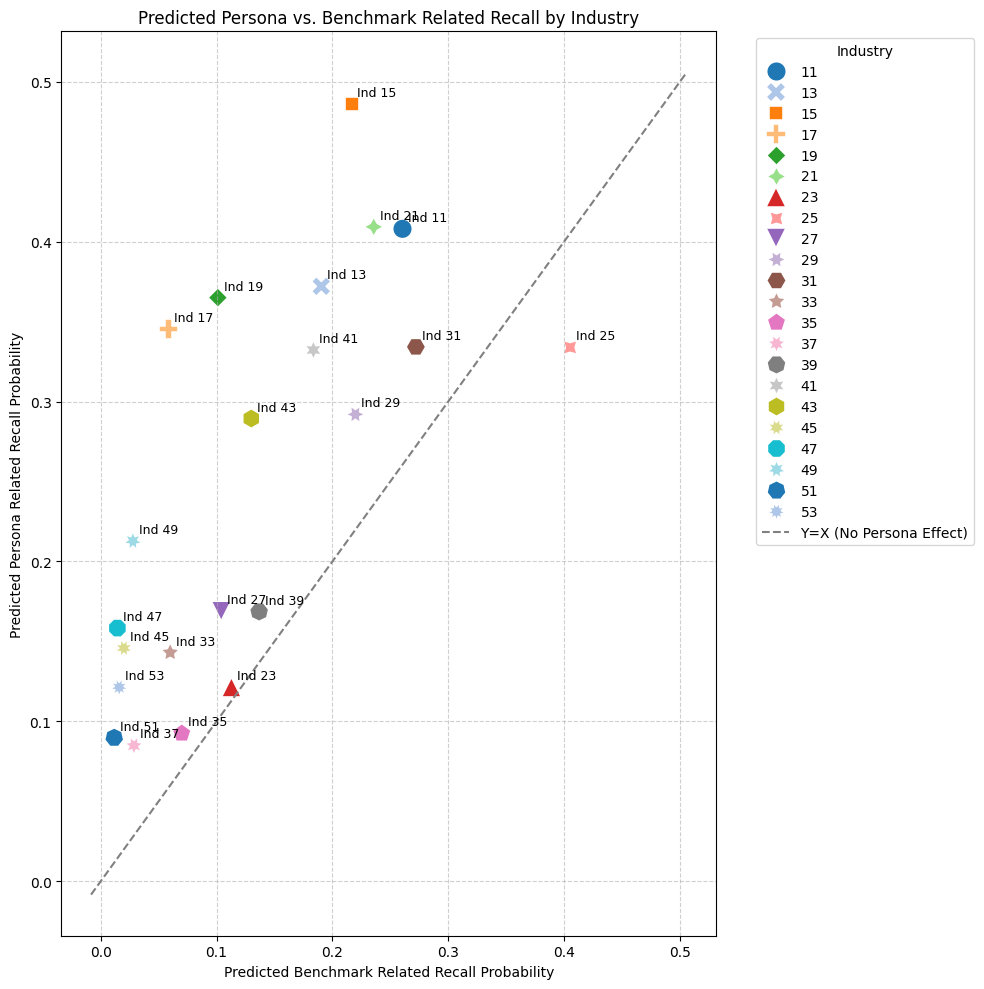


Predicted Probabilities by Industry and Prompt (for Plotting):
   industry  benchmark   persona
0        11   0.260536  0.408036
1        13   0.190417  0.372083
2        15   0.216667  0.485833
3        17   0.058393  0.345357
4        19   0.101167  0.365000
5        21   0.235714  0.409286
6        23   0.112857  0.121429
7        25   0.405323  0.333871
8        27   0.104000  0.169000
9        29   0.219888  0.292022
10       31   0.272105  0.334211
11       33   0.060000  0.143077
12       35   0.070000  0.092500
13       37   0.028750  0.085000
14       39   0.136774  0.168710
15       41   0.183636  0.332273
16       43   0.130000  0.289412
17       45   0.020000  0.145833
18       47   0.014426  0.158361
19       49   0.027800  0.212800
20       51   0.011682  0.089813
21       53   0.015962  0.121346


In [641]:
# --- Code for Industry Plot ---
# (Assumes your 'df' DataFrame also contains an 'industry' column)

# Define industry-specific model formula
model_formula_industry = 'successes + failures ~ C(prompt, Treatment(reference="benchmark")) + C(industry) + C(prompt, Treatment(reference="benchmark")):C(industry)'

# Assuming 'industry' column exists in your df
all_industries = sorted(df['industry'].unique()) # Get unique industries from your actual data

# Fit GEE model for Related Recall with Industry interaction
gee_model_industry = smf.gee(
    model_formula_industry,
    data=df, # Use your actual filtered df here
    groups=df[group_var], # Use the same 'code_id' as cluster variable
    family=sm.families.Binomial(),
    cov_type='robust',
    # scale=None # Uncomment if you explicitly use scale=None in your actual model
)
gee_results_industry = gee_model_industry.fit()

print("\n--- GEE Results: Related Recall ~ prompt * industry ---")
print(gee_results_industry.summary())

# --- Generate Predictions for Industry Plotting ---
predict_df_industry = pd.DataFrame([(ind, p) for ind in all_industries for p in all_prompts], columns=['industry', 'prompt'])
predict_df_industry['trials'] = 10 # Needed for prediction context

# Use patsy.dmatrix for industry design matrix
formula_for_dmatrix_industry = 'C(prompt, Treatment(reference="benchmark")) + C(industry) + C(prompt, Treatment(reference="benchmark")):C(industry)'

design_matrix_industry = patsy.dmatrix(
    formula_for_dmatrix_industry,
    data=predict_df_industry,
    return_type='dataframe'
)

# Align columns for industry prediction
params_industry = gee_results_industry.params
aligned_design_matrix_industry = pd.DataFrame(0, index=design_matrix_industry.index, columns=params_industry.index)
for col in aligned_design_matrix_industry.columns:
    if col in design_matrix_industry.columns:
        aligned_design_matrix_industry[col] = design_matrix_industry[col]

# Calculate linear predictor and probabilities for industry
linear_predictor_industry = aligned_design_matrix_industry.dot(params_industry)
predicted_probs_industry = 1 / (1 + np.exp(-linear_predictor_industry))

predict_df_industry['predicted_prob'] = predicted_probs_industry

# Pivot for plotting
plot_df_industry = predict_df_industry.pivot(index='industry', columns='prompt', values='predicted_prob').reset_index()
plot_df_industry.columns.name = None

# --- Plotting for Industry ---
plt.figure(figsize=(10, 10))
sns.scatterplot(x='benchmark', y='persona', data=plot_df_industry, hue='industry', s=200, style='industry', markers=True, legend='full', palette='tab20') # Use a palette with more colors

# Add labels for each point
for i, row in plot_df_industry.iterrows():
    plt.text(row['benchmark'] + 0.005, row['persona'] + 0.005, f'Ind {row["industry"]}', fontsize=9)

# Add a Y=X line for comparison
x_vals_ind = np.linspace(min(plot_df_industry['benchmark'].min(), plot_df_industry['persona'].min()) - 0.02,
                         max(plot_df_industry['benchmark'].max(), plot_df_industry['persona'].max()) + 0.02, 100)
plt.plot(x_vals_ind, x_vals_ind, color='gray', linestyle='--', label='Y=X (No Persona Effect)')

plt.title('Predicted Persona vs. Benchmark Related Recall by Industry')
plt.xlabel('Predicted Benchmark Related Recall Probability')
plt.ylabel('Predicted Persona Related Recall Probability')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nPredicted Probabilities by Industry and Prompt (for Plotting):")
print(plot_df_industry)